# Object Detection with Faster RCNN

Code is for the following video: https://www.youtube.com/watch?v=Uc90rr5jbA4&t=71s

Do give this notebook a thumbs-up if you liked it. Thanks!

In [250]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

We require the latest version of torchvision

Here are all the necessary libraries

In [251]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [252]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [253]:
print(torch.__version__)
print(torchvision.__version__)

2.1.2+cu121
0.16.2+cu121


PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you wanted, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

That is out of scope for this notebook, however.

In [205]:
# our dataset is in cocoformat, we will need pypcoco tools
from pycocotools.coco import COCO

In [206]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [207]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(640, 640), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(640, 640), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [208]:
import os
import cv2
import copy
import torch
from torchvision import datasets
from pycocotools.coco import COCO

class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split  # train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))  # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    def get_image_name(self, index):
        """Retrieve the image name for the given index."""
        id = self.ids[index]
        return self.coco.loadImgs(id)[0]['file_name']
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(target)
        
#         print(f"Original bounding boxes for {index}: {target}")
    
        boxes = [t['bbox'] + [t['category_id']] for t in target]  # required annotation format for albumentations
    
        height, width, _ = image.shape  # Get image dimensions
    
        # Filter out bounding boxes with invalid coordinates
        valid_boxes = []
        for box in boxes:
            x_min, y_min, w, h, category_id = box
            x_max, y_max = x_min + w, y_min + h
    
            # Adjust the coordinates check to consider the image dimensions
            if 0 <= x_min <= width and 0 <= y_min <= height and 0 <= x_max <= width and 0 <= y_max <= height:
                valid_boxes.append(box)

        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=valid_boxes)
            image = transformed['image']
            boxes = transformed['bboxes']

        new_boxes = []  # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        # Initialize 'targ' dictionary with keys and empty tensors
        targ = {
            'boxes': torch.zeros((0, 4), dtype=torch.float32),
            'labels': torch.tensor([], dtype=torch.int64),
            'image_id': torch.tensor([], dtype=torch.int64),
            'area': torch.tensor([], dtype=torch.float32),
            'iscrowd': torch.tensor([], dtype=torch.int64)
        }

        # Update 'targ' dictionary if there are valid boxes
        if new_boxes:
            boxes = torch.tensor(new_boxes, dtype=torch.float32)
            targ['boxes'] = boxes
            targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
            targ['image_id'] = torch.tensor([t['image_id'] for t in target])
            targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # different area calculation
            targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
            
#         print(f"Processed bounding boxes for {index}: {boxes}")

        return image.div(255), targ  # scale images


    def __len__(self):
        return len(self.ids)


In [209]:
dataset_path = "/rsrch5/home/plm/yshokrollahi/dataset_frcnn"

In [210]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


{0: {'id': 0, 'name': 'class_0'},
 1: {'id': 1, 'name': 'class_1'},
 2: {'id': 2, 'name': 'class_2'}}

This code just gets a list of classes

In [211]:
classes = [i[1]['name'] for i in categories.items()]
classes

['class_0', 'class_1', 'class_2']

In [212]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

Image Name: rotated_vertically_flipped_35_roi_429.jpg
Bounding boxes are present.


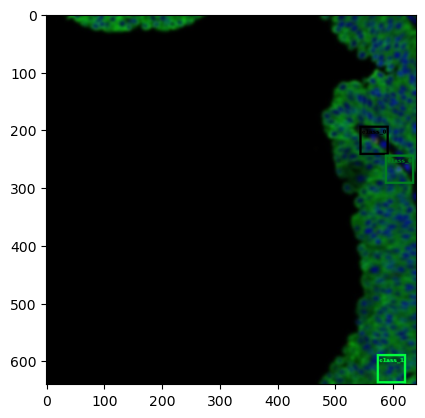

In [213]:
# Load a sample
sample = train_dataset[23]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)

# Retrieve and print the image name
image_name = train_dataset.get_image_name(50)
print(f"Image Name: {image_name}")

# Check if there are bounding boxes
if len(sample[1]['boxes']) > 0:
    print("Bounding boxes are present.")
else:
    print("No bounding boxes.")

# Draw and display the image with bounding boxes (if any)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))
plt.show()


In [214]:
len(train_dataset)

8408

## Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [215]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [216]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [217]:
# Define a new batch size
new_batch_size = 16  # for example, increase to 8; adjust this based on your GPU memory

# Create the DataLoader with the new batch size
train_loader = DataLoader(train_dataset, 
                          batch_size=new_batch_size, 
                          shuffle=True, 
                          num_workers=4, 
                          pin_memory=True,  # set to True if using a GPU
                          collate_fn=collate_fn)

# Now you can use the train_loader as before

The following blocks ensures that the model can take in the data and that it will not crash during training

In [218]:
images,targets = next(iter(train_loader))


In [219]:
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [220]:
device = torch.device("cuda") # use GPU to train

In [221]:
model = model.to(device)

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [222]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [223]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [224]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [225]:
num_epochs = 250
model_save_path = 'frcnn_models'  # Define the directory to save the models

# Create the directory if it does not exist
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    # lr_scheduler.step() # Uncomment if you are using a learning rate scheduler

    # Save the model every 25 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }
        save_path = os.path.join(model_save_path, f'checkpoint_epoch_{epoch + 1}.pth')
        torch.save(checkpoint, save_path)
        print(f'Model saved at epoch {epoch + 1} in {save_path}')

100%|█████████████████████████████████████████| 526/526 [01:13<00:00,  7.16it/s]


Epoch 0, lr: 0.010000, loss: 0.452630, loss_classifier: 0.232385, loss_box: 0.115506, loss_rpn_box: 0.013081, loss_object: 0.091658


100%|█████████████████████████████████████████| 526/526 [01:11<00:00,  7.34it/s]


Epoch 1, lr: 0.010000, loss: 0.400735, loss_classifier: 0.216934, loss_box: 0.101833, loss_rpn_box: 0.010405, loss_object: 0.071563


100%|█████████████████████████████████████████| 526/526 [01:11<00:00,  7.41it/s]


Epoch 2, lr: 0.010000, loss: 0.387840, loss_classifier: 0.214046, loss_box: 0.100171, loss_rpn_box: 0.009647, loss_object: 0.063977


100%|█████████████████████████████████████████| 526/526 [01:10<00:00,  7.45it/s]


Epoch 3, lr: 0.010000, loss: 0.375123, loss_classifier: 0.207039, loss_box: 0.100708, loss_rpn_box: 0.009284, loss_object: 0.058093


100%|█████████████████████████████████████████| 526/526 [01:09<00:00,  7.59it/s]


Epoch 4, lr: 0.010000, loss: 0.362337, loss_classifier: 0.198003, loss_box: 0.102317, loss_rpn_box: 0.009107, loss_object: 0.052910


100%|█████████████████████████████████████████| 526/526 [01:08<00:00,  7.65it/s]


Epoch 5, lr: 0.010000, loss: 0.350884, loss_classifier: 0.190429, loss_box: 0.104399, loss_rpn_box: 0.008687, loss_object: 0.047369


100%|█████████████████████████████████████████| 526/526 [01:07<00:00,  7.77it/s]


Epoch 6, lr: 0.010000, loss: 0.344758, loss_classifier: 0.182345, loss_box: 0.111341, loss_rpn_box: 0.008644, loss_object: 0.042428


100%|█████████████████████████████████████████| 526/526 [01:07<00:00,  7.83it/s]


Epoch 7, lr: 0.010000, loss: 0.332393, loss_classifier: 0.172329, loss_box: 0.113351, loss_rpn_box: 0.008325, loss_object: 0.038388


100%|█████████████████████████████████████████| 526/526 [01:06<00:00,  7.90it/s]


Epoch 8, lr: 0.010000, loss: 0.320775, loss_classifier: 0.159638, loss_box: 0.118000, loss_rpn_box: 0.008291, loss_object: 0.034846


100%|█████████████████████████████████████████| 526/526 [01:05<00:00,  8.00it/s]


Epoch 9, lr: 0.010000, loss: 0.311586, loss_classifier: 0.151053, loss_box: 0.120000, loss_rpn_box: 0.008159, loss_object: 0.032375
Model saved at epoch 10 in frcnn_models/checkpoint_epoch_10.pth


100%|█████████████████████████████████████████| 526/526 [01:05<00:00,  8.05it/s]


Epoch 10, lr: 0.010000, loss: 0.301390, loss_classifier: 0.139753, loss_box: 0.125010, loss_rpn_box: 0.007939, loss_object: 0.028688


100%|█████████████████████████████████████████| 526/526 [01:05<00:00,  8.05it/s]


Epoch 11, lr: 0.010000, loss: 0.290677, loss_classifier: 0.128531, loss_box: 0.127405, loss_rpn_box: 0.007839, loss_object: 0.026902


100%|█████████████████████████████████████████| 526/526 [01:05<00:00,  8.09it/s]


Epoch 12, lr: 0.010000, loss: 0.278929, loss_classifier: 0.120016, loss_box: 0.126174, loss_rpn_box: 0.007690, loss_object: 0.025049


100%|█████████████████████████████████████████| 526/526 [01:04<00:00,  8.14it/s]


Epoch 13, lr: 0.010000, loss: 0.268850, loss_classifier: 0.109538, loss_box: 0.128383, loss_rpn_box: 0.007619, loss_object: 0.023310


100%|█████████████████████████████████████████| 526/526 [01:03<00:00,  8.25it/s]


Epoch 14, lr: 0.010000, loss: 0.259305, loss_classifier: 0.101876, loss_box: 0.128553, loss_rpn_box: 0.007493, loss_object: 0.021384


100%|█████████████████████████████████████████| 526/526 [01:03<00:00,  8.23it/s]


Epoch 15, lr: 0.010000, loss: 0.252707, loss_classifier: 0.097641, loss_box: 0.127446, loss_rpn_box: 0.007351, loss_object: 0.020270


100%|█████████████████████████████████████████| 526/526 [01:03<00:00,  8.34it/s]


Epoch 16, lr: 0.010000, loss: 0.244710, loss_classifier: 0.090475, loss_box: 0.127734, loss_rpn_box: 0.007316, loss_object: 0.019184


100%|█████████████████████████████████████████| 526/526 [01:03<00:00,  8.32it/s]


Epoch 17, lr: 0.010000, loss: 0.239012, loss_classifier: 0.085798, loss_box: 0.127929, loss_rpn_box: 0.007117, loss_object: 0.018167


100%|█████████████████████████████████████████| 526/526 [01:03<00:00,  8.34it/s]


Epoch 18, lr: 0.010000, loss: 0.232517, loss_classifier: 0.080247, loss_box: 0.128090, loss_rpn_box: 0.007024, loss_object: 0.017157


100%|█████████████████████████████████████████| 526/526 [01:02<00:00,  8.42it/s]


Epoch 19, lr: 0.010000, loss: 0.228321, loss_classifier: 0.077376, loss_box: 0.128084, loss_rpn_box: 0.006899, loss_object: 0.015961
Model saved at epoch 20 in frcnn_models/checkpoint_epoch_20.pth


100%|█████████████████████████████████████████| 526/526 [01:02<00:00,  8.41it/s]


Epoch 20, lr: 0.010000, loss: 0.223099, loss_classifier: 0.075094, loss_box: 0.125569, loss_rpn_box: 0.006847, loss_object: 0.015589


100%|█████████████████████████████████████████| 526/526 [01:02<00:00,  8.39it/s]


Epoch 21, lr: 0.010000, loss: 0.218541, loss_classifier: 0.070962, loss_box: 0.126134, loss_rpn_box: 0.006733, loss_object: 0.014711


100%|█████████████████████████████████████████| 526/526 [01:02<00:00,  8.40it/s]


Epoch 22, lr: 0.010000, loss: 0.215815, loss_classifier: 0.069843, loss_box: 0.125049, loss_rpn_box: 0.006647, loss_object: 0.014276


100%|█████████████████████████████████████████| 526/526 [01:01<00:00,  8.53it/s]


Epoch 23, lr: 0.010000, loss: 0.212456, loss_classifier: 0.067493, loss_box: 0.125298, loss_rpn_box: 0.006560, loss_object: 0.013104


100%|█████████████████████████████████████████| 526/526 [01:01<00:00,  8.53it/s]


Epoch 24, lr: 0.010000, loss: 0.204959, loss_classifier: 0.061981, loss_box: 0.124256, loss_rpn_box: 0.006433, loss_object: 0.012289


100%|█████████████████████████████████████████| 526/526 [01:01<00:00,  8.53it/s]


Epoch 25, lr: 0.010000, loss: 0.204261, loss_classifier: 0.063496, loss_box: 0.122179, loss_rpn_box: 0.006355, loss_object: 0.012232


100%|█████████████████████████████████████████| 526/526 [01:01<00:00,  8.56it/s]


Epoch 26, lr: 0.010000, loss: 0.200053, loss_classifier: 0.061544, loss_box: 0.119996, loss_rpn_box: 0.006281, loss_object: 0.012232


100%|█████████████████████████████████████████| 526/526 [01:01<00:00,  8.56it/s]


Epoch 27, lr: 0.010000, loss: 0.195759, loss_classifier: 0.059317, loss_box: 0.118603, loss_rpn_box: 0.006197, loss_object: 0.011642


100%|█████████████████████████████████████████| 526/526 [01:01<00:00,  8.57it/s]


Epoch 28, lr: 0.010000, loss: 0.193092, loss_classifier: 0.059407, loss_box: 0.116151, loss_rpn_box: 0.006118, loss_object: 0.011416


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.63it/s]


Epoch 29, lr: 0.010000, loss: 0.190101, loss_classifier: 0.056187, loss_box: 0.117029, loss_rpn_box: 0.005971, loss_object: 0.010915
Model saved at epoch 30 in frcnn_models/checkpoint_epoch_30.pth


100%|█████████████████████████████████████████| 526/526 [01:01<00:00,  8.55it/s]


Epoch 30, lr: 0.010000, loss: 0.189126, loss_classifier: 0.055594, loss_box: 0.117379, loss_rpn_box: 0.005952, loss_object: 0.010201


100%|█████████████████████████████████████████| 526/526 [01:01<00:00,  8.60it/s]


Epoch 31, lr: 0.010000, loss: 0.188740, loss_classifier: 0.057249, loss_box: 0.115029, loss_rpn_box: 0.005870, loss_object: 0.010592


100%|█████████████████████████████████████████| 526/526 [01:01<00:00,  8.62it/s]


Epoch 32, lr: 0.010000, loss: 0.182904, loss_classifier: 0.053768, loss_box: 0.113430, loss_rpn_box: 0.005778, loss_object: 0.009928


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.68it/s]


Epoch 33, lr: 0.010000, loss: 0.181101, loss_classifier: 0.052929, loss_box: 0.112907, loss_rpn_box: 0.005692, loss_object: 0.009574


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.63it/s]


Epoch 34, lr: 0.010000, loss: 0.177783, loss_classifier: 0.051564, loss_box: 0.111146, loss_rpn_box: 0.005589, loss_object: 0.009483


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.62it/s]


Epoch 35, lr: 0.010000, loss: 0.180068, loss_classifier: 0.057064, loss_box: 0.106348, loss_rpn_box: 0.005641, loss_object: 0.011015


100%|█████████████████████████████████████████| 526/526 [01:01<00:00,  8.62it/s]


Epoch 36, lr: 0.010000, loss: 0.174723, loss_classifier: 0.053295, loss_box: 0.105648, loss_rpn_box: 0.005517, loss_object: 0.010263


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.76it/s]


Epoch 37, lr: 0.010000, loss: 0.171364, loss_classifier: 0.048611, loss_box: 0.108492, loss_rpn_box: 0.005463, loss_object: 0.008797


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.64it/s]


Epoch 38, lr: 0.010000, loss: 0.169257, loss_classifier: 0.048042, loss_box: 0.107463, loss_rpn_box: 0.005295, loss_object: 0.008457


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.65it/s]


Epoch 39, lr: 0.010000, loss: 0.167970, loss_classifier: 0.048995, loss_box: 0.104772, loss_rpn_box: 0.005286, loss_object: 0.008917
Model saved at epoch 40 in frcnn_models/checkpoint_epoch_40.pth


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.73it/s]


Epoch 40, lr: 0.010000, loss: 0.164865, loss_classifier: 0.046523, loss_box: 0.105155, loss_rpn_box: 0.005185, loss_object: 0.008001


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.68it/s]


Epoch 41, lr: 0.010000, loss: 0.166377, loss_classifier: 0.048280, loss_box: 0.104406, loss_rpn_box: 0.005193, loss_object: 0.008498


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.78it/s]


Epoch 42, lr: 0.010000, loss: 0.161997, loss_classifier: 0.045010, loss_box: 0.104171, loss_rpn_box: 0.005093, loss_object: 0.007723


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.78it/s]


Epoch 43, lr: 0.010000, loss: 0.160542, loss_classifier: 0.044864, loss_box: 0.103083, loss_rpn_box: 0.005041, loss_object: 0.007554


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.72it/s]


Epoch 44, lr: 0.010000, loss: 0.160393, loss_classifier: 0.045536, loss_box: 0.102115, loss_rpn_box: 0.005011, loss_object: 0.007731


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.69it/s]


Epoch 45, lr: 0.010000, loss: 0.157566, loss_classifier: 0.044003, loss_box: 0.101238, loss_rpn_box: 0.004896, loss_object: 0.007429


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.78it/s]


Epoch 46, lr: 0.010000, loss: 0.157781, loss_classifier: 0.045358, loss_box: 0.099920, loss_rpn_box: 0.004871, loss_object: 0.007632


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.81it/s]


Epoch 47, lr: 0.010000, loss: 0.153790, loss_classifier: 0.042983, loss_box: 0.098841, loss_rpn_box: 0.004784, loss_object: 0.007182


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.87it/s]


Epoch 48, lr: 0.010000, loss: 0.149951, loss_classifier: 0.041233, loss_box: 0.097247, loss_rpn_box: 0.004734, loss_object: 0.006736


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.75it/s]


Epoch 49, lr: 0.010000, loss: 0.152709, loss_classifier: 0.043248, loss_box: 0.097603, loss_rpn_box: 0.004722, loss_object: 0.007136
Model saved at epoch 50 in frcnn_models/checkpoint_epoch_50.pth


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.77it/s]


Epoch 50, lr: 0.010000, loss: 0.147611, loss_classifier: 0.041943, loss_box: 0.093677, loss_rpn_box: 0.004697, loss_object: 0.007295


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.82it/s]


Epoch 51, lr: 0.010000, loss: 0.146401, loss_classifier: 0.040572, loss_box: 0.094450, loss_rpn_box: 0.004554, loss_object: 0.006825


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.81it/s]


Epoch 52, lr: 0.010000, loss: 0.147374, loss_classifier: 0.041620, loss_box: 0.094386, loss_rpn_box: 0.004567, loss_object: 0.006801


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.90it/s]


Epoch 53, lr: 0.010000, loss: 0.144585, loss_classifier: 0.039997, loss_box: 0.093648, loss_rpn_box: 0.004468, loss_object: 0.006472


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.75it/s]


Epoch 54, lr: 0.010000, loss: 0.141231, loss_classifier: 0.038063, loss_box: 0.092662, loss_rpn_box: 0.004390, loss_object: 0.006116


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.69it/s]


Epoch 55, lr: 0.010000, loss: 0.157386, loss_classifier: 0.055079, loss_box: 0.087295, loss_rpn_box: 0.004580, loss_object: 0.010432


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.88it/s]


Epoch 56, lr: 0.010000, loss: 0.140101, loss_classifier: 0.038746, loss_box: 0.090648, loss_rpn_box: 0.004366, loss_object: 0.006342


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.90it/s]


Epoch 57, lr: 0.010000, loss: 0.140298, loss_classifier: 0.038406, loss_box: 0.091174, loss_rpn_box: 0.004326, loss_object: 0.006392


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.89it/s]


Epoch 58, lr: 0.010000, loss: 0.135979, loss_classifier: 0.036709, loss_box: 0.089063, loss_rpn_box: 0.004279, loss_object: 0.005929


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.81it/s]


Epoch 59, lr: 0.010000, loss: 0.143131, loss_classifier: 0.043522, loss_box: 0.088124, loss_rpn_box: 0.004278, loss_object: 0.007208
Model saved at epoch 60 in frcnn_models/checkpoint_epoch_60.pth


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.73it/s]


Epoch 60, lr: 0.010000, loss: 0.143321, loss_classifier: 0.045531, loss_box: 0.085455, loss_rpn_box: 0.004323, loss_object: 0.008012


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.78it/s]


Epoch 61, lr: 0.010000, loss: 0.135055, loss_classifier: 0.036803, loss_box: 0.088154, loss_rpn_box: 0.004189, loss_object: 0.005909


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.89it/s]


Epoch 62, lr: 0.010000, loss: 0.137381, loss_classifier: 0.039219, loss_box: 0.087719, loss_rpn_box: 0.004156, loss_object: 0.006287


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.73it/s]


Epoch 63, lr: 0.010000, loss: 0.134998, loss_classifier: 0.038298, loss_box: 0.086502, loss_rpn_box: 0.004146, loss_object: 0.006052


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.91it/s]


Epoch 64, lr: 0.010000, loss: 0.130445, loss_classifier: 0.034440, loss_box: 0.086650, loss_rpn_box: 0.004028, loss_object: 0.005327


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.97it/s]


Epoch 65, lr: 0.010000, loss: 0.129818, loss_classifier: 0.034996, loss_box: 0.085377, loss_rpn_box: 0.004033, loss_object: 0.005413


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.93it/s]


Epoch 66, lr: 0.010000, loss: 0.129520, loss_classifier: 0.035130, loss_box: 0.085073, loss_rpn_box: 0.003953, loss_object: 0.005365


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.86it/s]


Epoch 67, lr: 0.010000, loss: 0.127096, loss_classifier: 0.034858, loss_box: 0.082298, loss_rpn_box: 0.003950, loss_object: 0.005989


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.87it/s]


Epoch 68, lr: 0.010000, loss: 0.124611, loss_classifier: 0.032976, loss_box: 0.082603, loss_rpn_box: 0.003859, loss_object: 0.005173


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.93it/s]


Epoch 69, lr: 0.010000, loss: 0.127166, loss_classifier: 0.034737, loss_box: 0.083233, loss_rpn_box: 0.003880, loss_object: 0.005316
Model saved at epoch 70 in frcnn_models/checkpoint_epoch_70.pth


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.10it/s]


Epoch 70, lr: 0.010000, loss: 0.124315, loss_classifier: 0.032845, loss_box: 0.082800, loss_rpn_box: 0.003806, loss_object: 0.004864


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.84it/s]


Epoch 71, lr: 0.010000, loss: 0.129817, loss_classifier: 0.038470, loss_box: 0.081475, loss_rpn_box: 0.003837, loss_object: 0.006035


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.91it/s]


Epoch 72, lr: 0.010000, loss: 0.125830, loss_classifier: 0.037870, loss_box: 0.077475, loss_rpn_box: 0.003815, loss_object: 0.006669


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.89it/s]


Epoch 73, lr: 0.010000, loss: 0.123156, loss_classifier: 0.034180, loss_box: 0.080040, loss_rpn_box: 0.003771, loss_object: 0.005165


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.92it/s]


Epoch 74, lr: 0.010000, loss: 0.122060, loss_classifier: 0.032260, loss_box: 0.081466, loss_rpn_box: 0.003697, loss_object: 0.004637


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.95it/s]


Epoch 75, lr: 0.010000, loss: 0.121378, loss_classifier: 0.033477, loss_box: 0.079348, loss_rpn_box: 0.003655, loss_object: 0.004899


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.99it/s]


Epoch 76, lr: 0.010000, loss: 0.119331, loss_classifier: 0.032010, loss_box: 0.079009, loss_rpn_box: 0.003613, loss_object: 0.004699


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.98it/s]


Epoch 77, lr: 0.010000, loss: 0.120723, loss_classifier: 0.032670, loss_box: 0.079686, loss_rpn_box: 0.003600, loss_object: 0.004766


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.88it/s]


Epoch 78, lr: 0.010000, loss: 0.127626, loss_classifier: 0.040585, loss_box: 0.076879, loss_rpn_box: 0.003685, loss_object: 0.006476


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.83it/s]


Epoch 79, lr: 0.010000, loss: 0.121149, loss_classifier: 0.035302, loss_box: 0.076600, loss_rpn_box: 0.003591, loss_object: 0.005656
Model saved at epoch 80 in frcnn_models/checkpoint_epoch_80.pth


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.00it/s]


Epoch 80, lr: 0.010000, loss: 0.120078, loss_classifier: 0.033578, loss_box: 0.078113, loss_rpn_box: 0.003561, loss_object: 0.004826


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.95it/s]


Epoch 81, lr: 0.010000, loss: 0.119040, loss_classifier: 0.033716, loss_box: 0.076781, loss_rpn_box: 0.003542, loss_object: 0.005000


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.97it/s]


Epoch 82, lr: 0.010000, loss: 0.115178, loss_classifier: 0.031174, loss_box: 0.076033, loss_rpn_box: 0.003511, loss_object: 0.004459


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.01it/s]


Epoch 83, lr: 0.010000, loss: 0.117125, loss_classifier: 0.031621, loss_box: 0.077580, loss_rpn_box: 0.003407, loss_object: 0.004518


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.08it/s]


Epoch 84, lr: 0.010000, loss: 0.114816, loss_classifier: 0.030669, loss_box: 0.076432, loss_rpn_box: 0.003472, loss_object: 0.004242


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.10it/s]


Epoch 85, lr: 0.010000, loss: 0.114800, loss_classifier: 0.031738, loss_box: 0.075222, loss_rpn_box: 0.003363, loss_object: 0.004477


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.01it/s]


Epoch 86, lr: 0.010000, loss: 0.113284, loss_classifier: 0.031059, loss_box: 0.074605, loss_rpn_box: 0.003311, loss_object: 0.004309


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.92it/s]


Epoch 87, lr: 0.010000, loss: 0.112537, loss_classifier: 0.030550, loss_box: 0.074288, loss_rpn_box: 0.003300, loss_object: 0.004399


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.02it/s]


Epoch 88, lr: 0.010000, loss: 0.111799, loss_classifier: 0.030240, loss_box: 0.073903, loss_rpn_box: 0.003308, loss_object: 0.004349


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.00it/s]


Epoch 89, lr: 0.010000, loss: 0.108915, loss_classifier: 0.028788, loss_box: 0.073062, loss_rpn_box: 0.003187, loss_object: 0.003878
Model saved at epoch 90 in frcnn_models/checkpoint_epoch_90.pth


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.99it/s]


Epoch 90, lr: 0.010000, loss: 0.109236, loss_classifier: 0.029512, loss_box: 0.072211, loss_rpn_box: 0.003251, loss_object: 0.004261


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.89it/s]


Epoch 91, lr: 0.010000, loss: 0.115958, loss_classifier: 0.035637, loss_box: 0.071708, loss_rpn_box: 0.003314, loss_object: 0.005299


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.97it/s]


Epoch 92, lr: 0.010000, loss: 0.109244, loss_classifier: 0.029793, loss_box: 0.072064, loss_rpn_box: 0.003202, loss_object: 0.004186


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.98it/s]


Epoch 93, lr: 0.010000, loss: 0.108116, loss_classifier: 0.028945, loss_box: 0.072008, loss_rpn_box: 0.003169, loss_object: 0.003994


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.99it/s]


Epoch 94, lr: 0.010000, loss: 0.114175, loss_classifier: 0.036045, loss_box: 0.069734, loss_rpn_box: 0.003238, loss_object: 0.005158


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.87it/s]


Epoch 95, lr: 0.010000, loss: 0.108648, loss_classifier: 0.031905, loss_box: 0.068498, loss_rpn_box: 0.003210, loss_object: 0.005034


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.03it/s]


Epoch 96, lr: 0.010000, loss: 0.107959, loss_classifier: 0.029525, loss_box: 0.071330, loss_rpn_box: 0.003100, loss_object: 0.004004


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.04it/s]


Epoch 97, lr: 0.010000, loss: 0.105779, loss_classifier: 0.028454, loss_box: 0.070470, loss_rpn_box: 0.003088, loss_object: 0.003766


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.06it/s]


Epoch 98, lr: 0.010000, loss: 0.105682, loss_classifier: 0.028992, loss_box: 0.069637, loss_rpn_box: 0.003109, loss_object: 0.003944


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.02it/s]


Epoch 99, lr: 0.010000, loss: 0.107011, loss_classifier: 0.030468, loss_box: 0.069352, loss_rpn_box: 0.003049, loss_object: 0.004142
Model saved at epoch 100 in frcnn_models/checkpoint_epoch_100.pth


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.07it/s]


Epoch 100, lr: 0.010000, loss: 0.104393, loss_classifier: 0.027999, loss_box: 0.069705, loss_rpn_box: 0.003009, loss_object: 0.003680


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.02it/s]


Epoch 101, lr: 0.010000, loss: 0.106452, loss_classifier: 0.029988, loss_box: 0.069550, loss_rpn_box: 0.002964, loss_object: 0.003950


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.92it/s]


Epoch 102, lr: 0.010000, loss: 0.111068, loss_classifier: 0.035375, loss_box: 0.066928, loss_rpn_box: 0.003111, loss_object: 0.005654


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.10it/s]


Epoch 103, lr: 0.010000, loss: 0.104543, loss_classifier: 0.029220, loss_box: 0.067941, loss_rpn_box: 0.002989, loss_object: 0.004393


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.92it/s]


Epoch 104, lr: 0.010000, loss: 0.101349, loss_classifier: 0.027386, loss_box: 0.067254, loss_rpn_box: 0.002948, loss_object: 0.003762


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.01it/s]


Epoch 105, lr: 0.010000, loss: 0.101774, loss_classifier: 0.027566, loss_box: 0.067640, loss_rpn_box: 0.002898, loss_object: 0.003670


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.07it/s]


Epoch 106, lr: 0.010000, loss: 0.103807, loss_classifier: 0.029963, loss_box: 0.066652, loss_rpn_box: 0.002950, loss_object: 0.004242


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.96it/s]


Epoch 107, lr: 0.010000, loss: 0.109873, loss_classifier: 0.035319, loss_box: 0.066490, loss_rpn_box: 0.002979, loss_object: 0.005085


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.96it/s]


Epoch 108, lr: 0.010000, loss: 0.105042, loss_classifier: 0.031226, loss_box: 0.066406, loss_rpn_box: 0.002946, loss_object: 0.004464


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.95it/s]


Epoch 109, lr: 0.010000, loss: 0.101208, loss_classifier: 0.028898, loss_box: 0.065559, loss_rpn_box: 0.002873, loss_object: 0.003877
Model saved at epoch 110 in frcnn_models/checkpoint_epoch_110.pth


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.04it/s]


Epoch 110, lr: 0.010000, loss: 0.099536, loss_classifier: 0.027837, loss_box: 0.065184, loss_rpn_box: 0.002803, loss_object: 0.003712


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.05it/s]


Epoch 111, lr: 0.010000, loss: 0.097806, loss_classifier: 0.026976, loss_box: 0.064237, loss_rpn_box: 0.002824, loss_object: 0.003768


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.84it/s]


Epoch 112, lr: 0.010000, loss: 0.100088, loss_classifier: 0.028924, loss_box: 0.064122, loss_rpn_box: 0.002837, loss_object: 0.004205


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.03it/s]


Epoch 113, lr: 0.010000, loss: 0.097843, loss_classifier: 0.026681, loss_box: 0.064861, loss_rpn_box: 0.002770, loss_object: 0.003531


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.96it/s]


Epoch 114, lr: 0.010000, loss: 0.102922, loss_classifier: 0.031364, loss_box: 0.064200, loss_rpn_box: 0.002839, loss_object: 0.004519


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.09it/s]


Epoch 115, lr: 0.010000, loss: 0.096874, loss_classifier: 0.025840, loss_box: 0.064956, loss_rpn_box: 0.002736, loss_object: 0.003342


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.04it/s]


Epoch 116, lr: 0.010000, loss: 0.096730, loss_classifier: 0.026421, loss_box: 0.064300, loss_rpn_box: 0.002717, loss_object: 0.003292


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.13it/s]


Epoch 117, lr: 0.010000, loss: 0.094836, loss_classifier: 0.025507, loss_box: 0.063451, loss_rpn_box: 0.002653, loss_object: 0.003225


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.01it/s]


Epoch 118, lr: 0.010000, loss: 0.099601, loss_classifier: 0.029667, loss_box: 0.062831, loss_rpn_box: 0.002715, loss_object: 0.004389


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.09it/s]


Epoch 119, lr: 0.010000, loss: 0.094786, loss_classifier: 0.025733, loss_box: 0.063078, loss_rpn_box: 0.002643, loss_object: 0.003332
Model saved at epoch 120 in frcnn_models/checkpoint_epoch_120.pth


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.88it/s]


Epoch 120, lr: 0.010000, loss: 0.096349, loss_classifier: 0.027018, loss_box: 0.063142, loss_rpn_box: 0.002722, loss_object: 0.003467


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.95it/s]


Epoch 121, lr: 0.010000, loss: 0.102307, loss_classifier: 0.032272, loss_box: 0.062828, loss_rpn_box: 0.002715, loss_object: 0.004492


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.06it/s]


Epoch 122, lr: 0.010000, loss: 0.094889, loss_classifier: 0.026607, loss_box: 0.062030, loss_rpn_box: 0.002671, loss_object: 0.003580


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.12it/s]


Epoch 123, lr: 0.010000, loss: 0.094059, loss_classifier: 0.025870, loss_box: 0.062103, loss_rpn_box: 0.002614, loss_object: 0.003471


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.09it/s]


Epoch 124, lr: 0.010000, loss: 0.093270, loss_classifier: 0.025404, loss_box: 0.062189, loss_rpn_box: 0.002584, loss_object: 0.003093


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.11it/s]


Epoch 125, lr: 0.010000, loss: 0.093610, loss_classifier: 0.025789, loss_box: 0.062092, loss_rpn_box: 0.002532, loss_object: 0.003196


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.91it/s]


Epoch 126, lr: 0.010000, loss: 0.102562, loss_classifier: 0.033822, loss_box: 0.061091, loss_rpn_box: 0.002716, loss_object: 0.004933


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.10it/s]


Epoch 127, lr: 0.010000, loss: 0.093118, loss_classifier: 0.025769, loss_box: 0.061439, loss_rpn_box: 0.002628, loss_object: 0.003283


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.98it/s]


Epoch 128, lr: 0.010000, loss: 0.094723, loss_classifier: 0.026484, loss_box: 0.062455, loss_rpn_box: 0.002526, loss_object: 0.003258


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.03it/s]


Epoch 129, lr: 0.010000, loss: 0.099466, loss_classifier: 0.031030, loss_box: 0.061029, loss_rpn_box: 0.002626, loss_object: 0.004781
Model saved at epoch 130 in frcnn_models/checkpoint_epoch_130.pth


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.07it/s]


Epoch 130, lr: 0.010000, loss: 0.094415, loss_classifier: 0.028214, loss_box: 0.059869, loss_rpn_box: 0.002563, loss_object: 0.003769


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.01it/s]


Epoch 131, lr: 0.010000, loss: 0.095914, loss_classifier: 0.028838, loss_box: 0.060525, loss_rpn_box: 0.002591, loss_object: 0.003960


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.02it/s]


Epoch 132, lr: 0.010000, loss: 0.092861, loss_classifier: 0.027068, loss_box: 0.059569, loss_rpn_box: 0.002573, loss_object: 0.003651


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.10it/s]


Epoch 133, lr: 0.010000, loss: 0.095091, loss_classifier: 0.028391, loss_box: 0.060531, loss_rpn_box: 0.002570, loss_object: 0.003599


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.12it/s]


Epoch 134, lr: 0.010000, loss: 0.091161, loss_classifier: 0.025772, loss_box: 0.059680, loss_rpn_box: 0.002479, loss_object: 0.003229


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.09it/s]


Epoch 135, lr: 0.010000, loss: 0.092171, loss_classifier: 0.026601, loss_box: 0.059517, loss_rpn_box: 0.002492, loss_object: 0.003562


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.94it/s]


Epoch 136, lr: 0.010000, loss: 0.093359, loss_classifier: 0.027052, loss_box: 0.059973, loss_rpn_box: 0.002518, loss_object: 0.003817


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.04it/s]


Epoch 137, lr: 0.010000, loss: 0.090548, loss_classifier: 0.025860, loss_box: 0.058975, loss_rpn_box: 0.002427, loss_object: 0.003286


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.10it/s]


Epoch 138, lr: 0.010000, loss: 0.090292, loss_classifier: 0.025074, loss_box: 0.059727, loss_rpn_box: 0.002449, loss_object: 0.003042


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.08it/s]


Epoch 139, lr: 0.010000, loss: 0.089376, loss_classifier: 0.025192, loss_box: 0.058860, loss_rpn_box: 0.002400, loss_object: 0.002925
Model saved at epoch 140 in frcnn_models/checkpoint_epoch_140.pth


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.98it/s]


Epoch 140, lr: 0.010000, loss: 0.099543, loss_classifier: 0.033515, loss_box: 0.058716, loss_rpn_box: 0.002517, loss_object: 0.004795


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.03it/s]


Epoch 141, lr: 0.010000, loss: 0.089680, loss_classifier: 0.025422, loss_box: 0.058402, loss_rpn_box: 0.002404, loss_object: 0.003452


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.04it/s]


Epoch 142, lr: 0.010000, loss: 0.086623, loss_classifier: 0.023554, loss_box: 0.058047, loss_rpn_box: 0.002342, loss_object: 0.002680


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.04it/s]


Epoch 143, lr: 0.010000, loss: 0.089886, loss_classifier: 0.026216, loss_box: 0.058121, loss_rpn_box: 0.002387, loss_object: 0.003162


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.99it/s]


Epoch 144, lr: 0.010000, loss: 0.086481, loss_classifier: 0.023959, loss_box: 0.057378, loss_rpn_box: 0.002302, loss_object: 0.002841


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.16it/s]


Epoch 145, lr: 0.010000, loss: 0.087042, loss_classifier: 0.024233, loss_box: 0.057627, loss_rpn_box: 0.002295, loss_object: 0.002887


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.09it/s]


Epoch 146, lr: 0.010000, loss: 0.084238, loss_classifier: 0.023190, loss_box: 0.055824, loss_rpn_box: 0.002303, loss_object: 0.002921


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.20it/s]


Epoch 147, lr: 0.010000, loss: 0.085656, loss_classifier: 0.024655, loss_box: 0.055427, loss_rpn_box: 0.002320, loss_object: 0.003253


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.14it/s]


Epoch 148, lr: 0.010000, loss: 0.085032, loss_classifier: 0.024558, loss_box: 0.055066, loss_rpn_box: 0.002324, loss_object: 0.003083


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.08it/s]


Epoch 149, lr: 0.010000, loss: 0.085967, loss_classifier: 0.024468, loss_box: 0.056154, loss_rpn_box: 0.002282, loss_object: 0.003064
Model saved at epoch 150 in frcnn_models/checkpoint_epoch_150.pth


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.04it/s]


Epoch 150, lr: 0.010000, loss: 0.093936, loss_classifier: 0.031383, loss_box: 0.055841, loss_rpn_box: 0.002422, loss_object: 0.004290


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.89it/s]


Epoch 151, lr: 0.010000, loss: 0.098168, loss_classifier: 0.035256, loss_box: 0.054638, loss_rpn_box: 0.002512, loss_object: 0.005762


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.77it/s]


Epoch 152, lr: 0.010000, loss: 0.093297, loss_classifier: 0.030269, loss_box: 0.055987, loss_rpn_box: 0.002449, loss_object: 0.004592


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.07it/s]


Epoch 153, lr: 0.010000, loss: 0.086004, loss_classifier: 0.024472, loss_box: 0.056173, loss_rpn_box: 0.002345, loss_object: 0.003014


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.08it/s]


Epoch 154, lr: 0.010000, loss: 0.086031, loss_classifier: 0.025059, loss_box: 0.055404, loss_rpn_box: 0.002262, loss_object: 0.003305


100%|█████████████████████████████████████████| 526/526 [00:56<00:00,  9.25it/s]


Epoch 155, lr: 0.010000, loss: 0.083445, loss_classifier: 0.023221, loss_box: 0.055275, loss_rpn_box: 0.002274, loss_object: 0.002674


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.06it/s]


Epoch 156, lr: 0.010000, loss: 0.083739, loss_classifier: 0.024018, loss_box: 0.054496, loss_rpn_box: 0.002179, loss_object: 0.003046


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.03it/s]


Epoch 157, lr: 0.010000, loss: 0.084044, loss_classifier: 0.023952, loss_box: 0.054819, loss_rpn_box: 0.002234, loss_object: 0.003038


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.16it/s]


Epoch 158, lr: 0.010000, loss: 0.081228, loss_classifier: 0.022619, loss_box: 0.053598, loss_rpn_box: 0.002262, loss_object: 0.002749


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.06it/s]


Epoch 159, lr: 0.010000, loss: 0.084866, loss_classifier: 0.025081, loss_box: 0.054626, loss_rpn_box: 0.002206, loss_object: 0.002952
Model saved at epoch 160 in frcnn_models/checkpoint_epoch_160.pth


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.07it/s]


Epoch 160, lr: 0.010000, loss: 0.085939, loss_classifier: 0.025384, loss_box: 0.055232, loss_rpn_box: 0.002191, loss_object: 0.003132


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  8.97it/s]


Epoch 161, lr: 0.010000, loss: 0.084522, loss_classifier: 0.024711, loss_box: 0.054652, loss_rpn_box: 0.002186, loss_object: 0.002972


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.12it/s]


Epoch 162, lr: 0.010000, loss: 0.084525, loss_classifier: 0.024716, loss_box: 0.054503, loss_rpn_box: 0.002190, loss_object: 0.003115


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.13it/s]


Epoch 163, lr: 0.010000, loss: 0.081787, loss_classifier: 0.023314, loss_box: 0.053716, loss_rpn_box: 0.002121, loss_object: 0.002635


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.17it/s]


Epoch 164, lr: 0.010000, loss: 0.080498, loss_classifier: 0.022086, loss_box: 0.053734, loss_rpn_box: 0.002157, loss_object: 0.002521


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.19it/s]


Epoch 165, lr: 0.010000, loss: 0.081673, loss_classifier: 0.023449, loss_box: 0.053307, loss_rpn_box: 0.002199, loss_object: 0.002718


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.10it/s]


Epoch 166, lr: 0.010000, loss: 0.081105, loss_classifier: 0.023103, loss_box: 0.053201, loss_rpn_box: 0.002211, loss_object: 0.002589


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.03it/s]


Epoch 167, lr: 0.010000, loss: 0.081511, loss_classifier: 0.024173, loss_box: 0.051989, loss_rpn_box: 0.002062, loss_object: 0.003287


100%|█████████████████████████████████████████| 526/526 [01:00<00:00,  8.65it/s]


Epoch 168, lr: 0.010000, loss: 0.117680, loss_classifier: 0.051705, loss_box: 0.051343, loss_rpn_box: 0.002820, loss_object: 0.011812


100%|█████████████████████████████████████████| 526/526 [00:59<00:00,  8.89it/s]


Epoch 169, lr: 0.010000, loss: 0.083011, loss_classifier: 0.025228, loss_box: 0.051535, loss_rpn_box: 0.002325, loss_object: 0.003923
Model saved at epoch 170 in frcnn_models/checkpoint_epoch_170.pth


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.02it/s]


Epoch 170, lr: 0.010000, loss: 0.085571, loss_classifier: 0.027101, loss_box: 0.051865, loss_rpn_box: 0.002252, loss_object: 0.004353


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.06it/s]


Epoch 171, lr: 0.010000, loss: 0.080333, loss_classifier: 0.023292, loss_box: 0.051668, loss_rpn_box: 0.002207, loss_object: 0.003166


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.02it/s]


Epoch 172, lr: 0.010000, loss: 0.090903, loss_classifier: 0.031888, loss_box: 0.052172, loss_rpn_box: 0.002289, loss_object: 0.004554


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.00it/s]


Epoch 173, lr: 0.010000, loss: 0.083510, loss_classifier: 0.025899, loss_box: 0.051581, loss_rpn_box: 0.002222, loss_object: 0.003808


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.12it/s]


Epoch 174, lr: 0.010000, loss: 0.080098, loss_classifier: 0.022833, loss_box: 0.052405, loss_rpn_box: 0.002133, loss_object: 0.002728


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.11it/s]


Epoch 175, lr: 0.010000, loss: 0.079369, loss_classifier: 0.022744, loss_box: 0.051689, loss_rpn_box: 0.002098, loss_object: 0.002837


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.18it/s]


Epoch 176, lr: 0.010000, loss: 0.079195, loss_classifier: 0.022340, loss_box: 0.052203, loss_rpn_box: 0.002076, loss_object: 0.002577


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.14it/s]


Epoch 177, lr: 0.010000, loss: 0.078521, loss_classifier: 0.022387, loss_box: 0.051676, loss_rpn_box: 0.002026, loss_object: 0.002431


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.18it/s]


Epoch 178, lr: 0.010000, loss: 0.078750, loss_classifier: 0.022343, loss_box: 0.051710, loss_rpn_box: 0.001996, loss_object: 0.002701


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.08it/s]


Epoch 179, lr: 0.010000, loss: 0.079994, loss_classifier: 0.024042, loss_box: 0.051103, loss_rpn_box: 0.002002, loss_object: 0.002846
Model saved at epoch 180 in frcnn_models/checkpoint_epoch_180.pth


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.20it/s]


Epoch 180, lr: 0.010000, loss: 0.076305, loss_classifier: 0.021652, loss_box: 0.050055, loss_rpn_box: 0.001989, loss_object: 0.002608


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.05it/s]


Epoch 181, lr: 0.010000, loss: 0.077402, loss_classifier: 0.021777, loss_box: 0.051209, loss_rpn_box: 0.001972, loss_object: 0.002444


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.23it/s]


Epoch 182, lr: 0.010000, loss: 0.075624, loss_classifier: 0.020885, loss_box: 0.050425, loss_rpn_box: 0.001941, loss_object: 0.002374


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.05it/s]


Epoch 183, lr: 0.010000, loss: 0.076365, loss_classifier: 0.021963, loss_box: 0.049857, loss_rpn_box: 0.001966, loss_object: 0.002579


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.17it/s]


Epoch 184, lr: 0.010000, loss: 0.075895, loss_classifier: 0.021326, loss_box: 0.050311, loss_rpn_box: 0.001950, loss_object: 0.002308


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.02it/s]


Epoch 185, lr: 0.010000, loss: 0.076417, loss_classifier: 0.021713, loss_box: 0.050342, loss_rpn_box: 0.001919, loss_object: 0.002443


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.15it/s]


Epoch 186, lr: 0.010000, loss: 0.074946, loss_classifier: 0.020973, loss_box: 0.049761, loss_rpn_box: 0.001888, loss_object: 0.002325


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.21it/s]


Epoch 187, lr: 0.010000, loss: 0.078919, loss_classifier: 0.023287, loss_box: 0.050946, loss_rpn_box: 0.001984, loss_object: 0.002702


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.13it/s]


Epoch 188, lr: 0.010000, loss: 0.076551, loss_classifier: 0.022591, loss_box: 0.049250, loss_rpn_box: 0.001922, loss_object: 0.002788


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.09it/s]


Epoch 189, lr: 0.010000, loss: 0.076317, loss_classifier: 0.022160, loss_box: 0.049790, loss_rpn_box: 0.001903, loss_object: 0.002465
Model saved at epoch 190 in frcnn_models/checkpoint_epoch_190.pth


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.03it/s]


Epoch 190, lr: 0.010000, loss: 0.084101, loss_classifier: 0.028406, loss_box: 0.049863, loss_rpn_box: 0.002032, loss_object: 0.003800


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.06it/s]


Epoch 191, lr: 0.010000, loss: 0.075518, loss_classifier: 0.022256, loss_box: 0.048634, loss_rpn_box: 0.002004, loss_object: 0.002624


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.11it/s]


Epoch 192, lr: 0.010000, loss: 0.076029, loss_classifier: 0.022327, loss_box: 0.049095, loss_rpn_box: 0.001935, loss_object: 0.002672


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.04it/s]


Epoch 193, lr: 0.010000, loss: 0.076159, loss_classifier: 0.022461, loss_box: 0.049058, loss_rpn_box: 0.001919, loss_object: 0.002721


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.13it/s]


Epoch 194, lr: 0.010000, loss: 0.077964, loss_classifier: 0.023592, loss_box: 0.049440, loss_rpn_box: 0.001925, loss_object: 0.003007


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.02it/s]


Epoch 195, lr: 0.010000, loss: 0.081790, loss_classifier: 0.027375, loss_box: 0.048251, loss_rpn_box: 0.002036, loss_object: 0.004127


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.13it/s]


Epoch 196, lr: 0.010000, loss: 0.073909, loss_classifier: 0.021597, loss_box: 0.047926, loss_rpn_box: 0.001890, loss_object: 0.002496


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.16it/s]


Epoch 197, lr: 0.010000, loss: 0.074238, loss_classifier: 0.021830, loss_box: 0.047994, loss_rpn_box: 0.001888, loss_object: 0.002526


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.02it/s]


Epoch 198, lr: 0.010000, loss: 0.080110, loss_classifier: 0.025583, loss_box: 0.049145, loss_rpn_box: 0.001971, loss_object: 0.003411


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.18it/s]


Epoch 199, lr: 0.010000, loss: 0.076710, loss_classifier: 0.022607, loss_box: 0.049305, loss_rpn_box: 0.001986, loss_object: 0.002813
Model saved at epoch 200 in frcnn_models/checkpoint_epoch_200.pth


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.13it/s]


Epoch 200, lr: 0.010000, loss: 0.073036, loss_classifier: 0.021041, loss_box: 0.047718, loss_rpn_box: 0.001877, loss_object: 0.002400


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.04it/s]


Epoch 201, lr: 0.010000, loss: 0.072043, loss_classifier: 0.021517, loss_box: 0.046116, loss_rpn_box: 0.001838, loss_object: 0.002572


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.21it/s]


Epoch 202, lr: 0.010000, loss: 0.071996, loss_classifier: 0.021118, loss_box: 0.046526, loss_rpn_box: 0.001868, loss_object: 0.002484


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.01it/s]


Epoch 203, lr: 0.010000, loss: 0.080207, loss_classifier: 0.026988, loss_box: 0.046988, loss_rpn_box: 0.001967, loss_object: 0.004264


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.05it/s]


Epoch 204, lr: 0.010000, loss: 0.073222, loss_classifier: 0.021654, loss_box: 0.047136, loss_rpn_box: 0.001889, loss_object: 0.002544


100%|█████████████████████████████████████████| 526/526 [00:56<00:00,  9.25it/s]


Epoch 205, lr: 0.010000, loss: 0.071376, loss_classifier: 0.020491, loss_box: 0.046849, loss_rpn_box: 0.001845, loss_object: 0.002190


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.17it/s]


Epoch 206, lr: 0.010000, loss: 0.070102, loss_classifier: 0.019892, loss_box: 0.046274, loss_rpn_box: 0.001788, loss_object: 0.002148


100%|█████████████████████████████████████████| 526/526 [00:56<00:00,  9.24it/s]


Epoch 207, lr: 0.010000, loss: 0.076511, loss_classifier: 0.023124, loss_box: 0.048810, loss_rpn_box: 0.001908, loss_object: 0.002669


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.15it/s]


Epoch 208, lr: 0.010000, loss: 0.073489, loss_classifier: 0.021810, loss_box: 0.047172, loss_rpn_box: 0.001871, loss_object: 0.002637


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.00it/s]


Epoch 209, lr: 0.010000, loss: 0.078687, loss_classifier: 0.026062, loss_box: 0.047407, loss_rpn_box: 0.001865, loss_object: 0.003353
Model saved at epoch 210 in frcnn_models/checkpoint_epoch_210.pth


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.04it/s]


Epoch 210, lr: 0.010000, loss: 0.074606, loss_classifier: 0.022512, loss_box: 0.047289, loss_rpn_box: 0.001897, loss_object: 0.002909


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.11it/s]


Epoch 211, lr: 0.010000, loss: 0.072630, loss_classifier: 0.021330, loss_box: 0.047039, loss_rpn_box: 0.001773, loss_object: 0.002488


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.16it/s]


Epoch 212, lr: 0.010000, loss: 0.072899, loss_classifier: 0.021235, loss_box: 0.047395, loss_rpn_box: 0.001823, loss_object: 0.002446


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.14it/s]


Epoch 213, lr: 0.010000, loss: 0.074731, loss_classifier: 0.022900, loss_box: 0.047126, loss_rpn_box: 0.001883, loss_object: 0.002822


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.18it/s]


Epoch 214, lr: 0.010000, loss: 0.072930, loss_classifier: 0.021779, loss_box: 0.046995, loss_rpn_box: 0.001789, loss_object: 0.002367


100%|█████████████████████████████████████████| 526/526 [00:56<00:00,  9.27it/s]


Epoch 215, lr: 0.010000, loss: 0.072710, loss_classifier: 0.021475, loss_box: 0.047106, loss_rpn_box: 0.001776, loss_object: 0.002353


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.15it/s]


Epoch 216, lr: 0.010000, loss: 0.074993, loss_classifier: 0.023259, loss_box: 0.046958, loss_rpn_box: 0.001813, loss_object: 0.002964


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.12it/s]


Epoch 217, lr: 0.010000, loss: 0.080952, loss_classifier: 0.027289, loss_box: 0.048240, loss_rpn_box: 0.001900, loss_object: 0.003523


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.06it/s]


Epoch 218, lr: 0.010000, loss: 0.072029, loss_classifier: 0.021546, loss_box: 0.046267, loss_rpn_box: 0.001878, loss_object: 0.002339


100%|█████████████████████████████████████████| 526/526 [00:56<00:00,  9.26it/s]


Epoch 219, lr: 0.010000, loss: 0.071458, loss_classifier: 0.020908, loss_box: 0.046638, loss_rpn_box: 0.001734, loss_object: 0.002179
Model saved at epoch 220 in frcnn_models/checkpoint_epoch_220.pth


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.15it/s]


Epoch 220, lr: 0.010000, loss: 0.074925, loss_classifier: 0.023700, loss_box: 0.046293, loss_rpn_box: 0.001867, loss_object: 0.003065


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.13it/s]


Epoch 221, lr: 0.010000, loss: 0.072215, loss_classifier: 0.022127, loss_box: 0.045457, loss_rpn_box: 0.001755, loss_object: 0.002876


100%|█████████████████████████████████████████| 526/526 [00:56<00:00,  9.25it/s]


Epoch 222, lr: 0.010000, loss: 0.068637, loss_classifier: 0.020009, loss_box: 0.044652, loss_rpn_box: 0.001774, loss_object: 0.002203


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.22it/s]


Epoch 223, lr: 0.010000, loss: 0.068300, loss_classifier: 0.019741, loss_box: 0.044568, loss_rpn_box: 0.001702, loss_object: 0.002290


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.14it/s]


Epoch 224, lr: 0.010000, loss: 0.076278, loss_classifier: 0.025866, loss_box: 0.045133, loss_rpn_box: 0.001877, loss_object: 0.003402


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.09it/s]


Epoch 225, lr: 0.010000, loss: 0.070194, loss_classifier: 0.021113, loss_box: 0.044791, loss_rpn_box: 0.001728, loss_object: 0.002562


100%|█████████████████████████████████████████| 526/526 [00:58<00:00,  9.06it/s]


Epoch 226, lr: 0.010000, loss: 0.069170, loss_classifier: 0.020098, loss_box: 0.045328, loss_rpn_box: 0.001705, loss_object: 0.002039


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.16it/s]


Epoch 227, lr: 0.010000, loss: 0.069636, loss_classifier: 0.020229, loss_box: 0.045461, loss_rpn_box: 0.001743, loss_object: 0.002203


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.10it/s]


Epoch 228, lr: 0.010000, loss: 0.068454, loss_classifier: 0.019686, loss_box: 0.045133, loss_rpn_box: 0.001690, loss_object: 0.001944


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.19it/s]


Epoch 229, lr: 0.010000, loss: 0.068965, loss_classifier: 0.020681, loss_box: 0.044259, loss_rpn_box: 0.001687, loss_object: 0.002338
Model saved at epoch 230 in frcnn_models/checkpoint_epoch_230.pth


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.17it/s]


Epoch 230, lr: 0.010000, loss: 0.069135, loss_classifier: 0.020528, loss_box: 0.044795, loss_rpn_box: 0.001699, loss_object: 0.002113


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.13it/s]


Epoch 231, lr: 0.010000, loss: 0.068432, loss_classifier: 0.019951, loss_box: 0.044760, loss_rpn_box: 0.001648, loss_object: 0.002073


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.19it/s]


Epoch 232, lr: 0.010000, loss: 0.070115, loss_classifier: 0.021284, loss_box: 0.044597, loss_rpn_box: 0.001755, loss_object: 0.002479


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.14it/s]


Epoch 233, lr: 0.010000, loss: 0.070288, loss_classifier: 0.021827, loss_box: 0.044035, loss_rpn_box: 0.001688, loss_object: 0.002738


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.11it/s]


Epoch 234, lr: 0.010000, loss: 0.069567, loss_classifier: 0.020794, loss_box: 0.044761, loss_rpn_box: 0.001698, loss_object: 0.002314


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.22it/s]


Epoch 235, lr: 0.010000, loss: 0.069847, loss_classifier: 0.021358, loss_box: 0.044267, loss_rpn_box: 0.001722, loss_object: 0.002500


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.13it/s]


Epoch 236, lr: 0.010000, loss: 0.070638, loss_classifier: 0.021675, loss_box: 0.044577, loss_rpn_box: 0.001686, loss_object: 0.002701


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.10it/s]


Epoch 237, lr: 0.010000, loss: 0.072675, loss_classifier: 0.023631, loss_box: 0.044455, loss_rpn_box: 0.001777, loss_object: 0.002813


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.16it/s]


Epoch 238, lr: 0.010000, loss: 0.068661, loss_classifier: 0.020679, loss_box: 0.043894, loss_rpn_box: 0.001670, loss_object: 0.002418


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.18it/s]


Epoch 239, lr: 0.010000, loss: 0.068271, loss_classifier: 0.020765, loss_box: 0.043418, loss_rpn_box: 0.001704, loss_object: 0.002384
Model saved at epoch 240 in frcnn_models/checkpoint_epoch_240.pth


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.15it/s]


Epoch 240, lr: 0.010000, loss: 0.069204, loss_classifier: 0.021193, loss_box: 0.043776, loss_rpn_box: 0.001661, loss_object: 0.002575


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.21it/s]


Epoch 241, lr: 0.010000, loss: 0.067617, loss_classifier: 0.019964, loss_box: 0.043888, loss_rpn_box: 0.001657, loss_object: 0.002109


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.09it/s]


Epoch 242, lr: 0.010000, loss: 0.073504, loss_classifier: 0.023938, loss_box: 0.044761, loss_rpn_box: 0.001778, loss_object: 0.003027


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.10it/s]


Epoch 243, lr: 0.010000, loss: 0.074343, loss_classifier: 0.025057, loss_box: 0.044026, loss_rpn_box: 0.001731, loss_object: 0.003529


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.15it/s]


Epoch 244, lr: 0.010000, loss: 0.067722, loss_classifier: 0.020315, loss_box: 0.043208, loss_rpn_box: 0.001680, loss_object: 0.002519


100%|█████████████████████████████████████████| 526/526 [00:56<00:00,  9.29it/s]


Epoch 245, lr: 0.010000, loss: 0.065402, loss_classifier: 0.018730, loss_box: 0.043117, loss_rpn_box: 0.001723, loss_object: 0.001832


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.14it/s]


Epoch 246, lr: 0.010000, loss: 0.068301, loss_classifier: 0.020413, loss_box: 0.044117, loss_rpn_box: 0.001676, loss_object: 0.002096


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.20it/s]


Epoch 247, lr: 0.010000, loss: 0.068504, loss_classifier: 0.020771, loss_box: 0.043759, loss_rpn_box: 0.001592, loss_object: 0.002383


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.15it/s]


Epoch 248, lr: 0.010000, loss: 0.075460, loss_classifier: 0.026238, loss_box: 0.043684, loss_rpn_box: 0.001771, loss_object: 0.003767


100%|█████████████████████████████████████████| 526/526 [00:57<00:00,  9.14it/s]


Epoch 249, lr: 0.010000, loss: 0.067911, loss_classifier: 0.021054, loss_box: 0.041971, loss_rpn_box: 0.001717, loss_object: 0.003169
Model saved at epoch 250 in frcnn_models/checkpoint_epoch_250.pth


# Save Model

In [226]:
# our learning rate was too low, due to a lr scheduler bug. For this task, we wont need a scheudul.er
# Save the final trained model
torch.save(model.state_dict(), "frcnn_models/checkpoint_epoch_250.pth")

In [227]:
# Load the trained model (assuming the model architecture is already defined)
model.load_state_dict(torch.load("frcnn_models/checkpoint_epoch_250.pth"))
model.eval()  # Set the model to evaluation mode if you are doing inference


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [228]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [229]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [236]:
img, _ = test_dataset[1]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [237]:
# it did learn

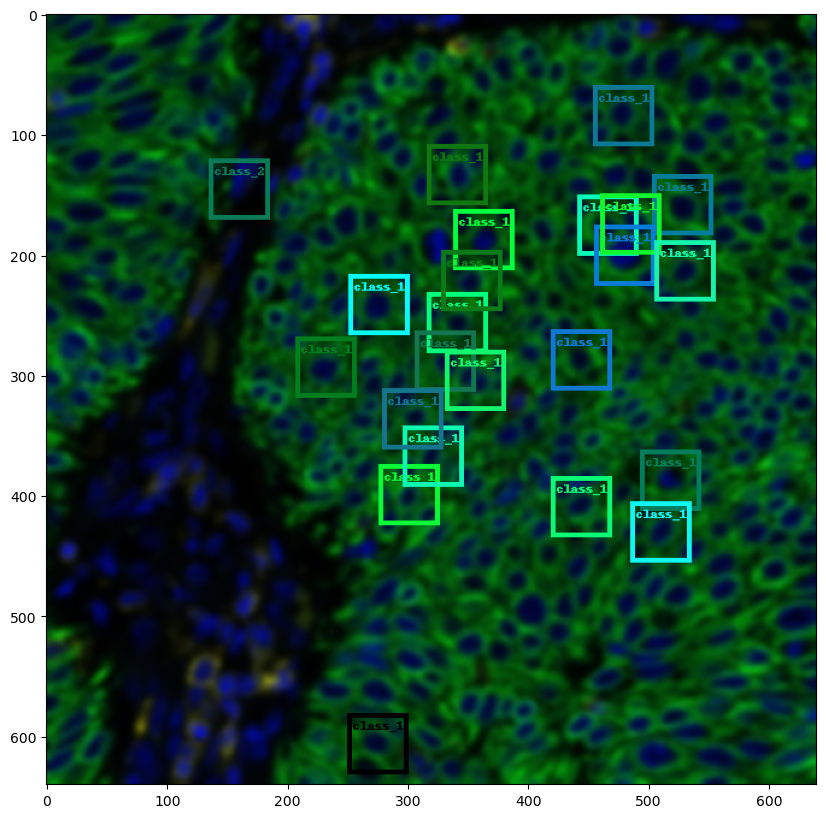

In [238]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [249]:
# Set the model to evaluation mode and clear the GPU Cache
model.eval()
torch.cuda.empty_cache()

# Load a test dataset image along with its annotations
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))
img, target = test_dataset[6]
img_int = torch.tensor(img*255, dtype=torch.uint8)

# Perform prediction
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

# Draw actual (ground truth) bounding boxes
actual_boxes_img = draw_bounding_boxes(
    img_int.clone(), 
    target['boxes'], 
    [classes[i] for i in target['labels']], 
    colors='blue', 
    width=4
)

# Set confidence threshold
confidence_threshold = 0.001

# Filter out predictions below the confidence threshold
pred_boxes = pred['boxes'][pred['scores'] > confidence_threshold]
pred_labels = pred['labels'][pred['scores'] > confidence_threshold]

# Draw predicted bounding boxes
predicted_boxes_img = draw_bounding_boxes(
    img_int.clone(), 
    pred_boxes, 
    [classes[i] for i in pred_labels.tolist()], 
    colors='red', 
    width=4
)

# Display the images side by side for comparison
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(actual_boxes_img.permute(1, 2, 0))
ax[0].set_title('Real Bounding Boxes')
ax[0].axis('off')

ax[1].imshow(predicted_boxes_img.permute(1, 2, 0))
ax[1].set_title('Predicted Bounding Boxes')
ax[1].axis('off')

plt.show()


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


ValueError: Number of boxes (5) and labels (6) mismatch. Please specify labels for each box.

In [233]:
def get_model_predictions(model, dataset, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for img, _ in dataset:
            img = img.to(device)
            prediction = model([img])
            predictions.append(prediction[0])

    return predictions

# Assuming test_dataset is already created
predictions = get_model_predictions(model, test_dataset, device)


In [234]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import json

def prepare_for_coco_evaluation(predictions, dataset):
    coco_results = []
    for img_id, prediction in zip(dataset.ids, predictions):  # Use actual image IDs from the dataset
        boxes = prediction['boxes'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()

        for idx in range(boxes.shape[0]):
            box = boxes[idx].tolist()
            score = float(scores[idx])
            label = int(labels[idx])

            coco_result = {
                "image_id": img_id,  # Use actual image ID
                "category_id": label,
                "bbox": [box[0], box[1], box[2] - box[0], box[3] - box[1]],
                "score": score
            }
            coco_results.append(coco_result)
    return coco_results



# Convert model predictions to COCO format
coco_predictions = prepare_for_coco_evaluation(predictions, test_dataset)

# Write to a file (COCO expects a JSON file)
with open('predictions.json', 'w') as f:
    json.dump(coco_predictions, f)

# Load the ground truth annotations
cocoGt = COCO('/rsrch5/home/plm/yshokrollahi/dataset_frcnn/test/_annotations.coco.json')

# Load the predictions
cocoDt = cocoGt.loadRes('predictions.json')

# Create COCO Eval object
cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')

# Evaluate on the dataset
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.12s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

# Retrain

In [198]:
# Define your model architecture exactly as before
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

# Load the weights
model.load_state_dict(torch.load("frcnn_models/checkpoint_epoch_150.pth"))


RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	Missing key(s) in state_dict: "backbone.body.0.0.weight", "backbone.body.0.1.weight", "backbone.body.0.1.bias", "backbone.body.0.1.running_mean", "backbone.body.0.1.running_var", "backbone.body.1.block.0.0.weight", "backbone.body.1.block.0.1.weight", "backbone.body.1.block.0.1.bias", "backbone.body.1.block.0.1.running_mean", "backbone.body.1.block.0.1.running_var", "backbone.body.1.block.1.0.weight", "backbone.body.1.block.1.1.weight", "backbone.body.1.block.1.1.bias", "backbone.body.1.block.1.1.running_mean", "backbone.body.1.block.1.1.running_var", "backbone.body.2.block.0.0.weight", "backbone.body.2.block.0.1.weight", "backbone.body.2.block.0.1.bias", "backbone.body.2.block.0.1.running_mean", "backbone.body.2.block.0.1.running_var", "backbone.body.2.block.1.0.weight", "backbone.body.2.block.1.1.weight", "backbone.body.2.block.1.1.bias", "backbone.body.2.block.1.1.running_mean", "backbone.body.2.block.1.1.running_var", "backbone.body.2.block.2.0.weight", "backbone.body.2.block.2.1.weight", "backbone.body.2.block.2.1.bias", "backbone.body.2.block.2.1.running_mean", "backbone.body.2.block.2.1.running_var", "backbone.body.3.block.0.0.weight", "backbone.body.3.block.0.1.weight", "backbone.body.3.block.0.1.bias", "backbone.body.3.block.0.1.running_mean", "backbone.body.3.block.0.1.running_var", "backbone.body.3.block.1.0.weight", "backbone.body.3.block.1.1.weight", "backbone.body.3.block.1.1.bias", "backbone.body.3.block.1.1.running_mean", "backbone.body.3.block.1.1.running_var", "backbone.body.3.block.2.0.weight", "backbone.body.3.block.2.1.weight", "backbone.body.3.block.2.1.bias", "backbone.body.3.block.2.1.running_mean", "backbone.body.3.block.2.1.running_var", "backbone.body.4.block.0.0.weight", "backbone.body.4.block.0.1.weight", "backbone.body.4.block.0.1.bias", "backbone.body.4.block.0.1.running_mean", "backbone.body.4.block.0.1.running_var", "backbone.body.4.block.1.0.weight", "backbone.body.4.block.1.1.weight", "backbone.body.4.block.1.1.bias", "backbone.body.4.block.1.1.running_mean", "backbone.body.4.block.1.1.running_var", "backbone.body.4.block.2.fc1.weight", "backbone.body.4.block.2.fc1.bias", "backbone.body.4.block.2.fc2.weight", "backbone.body.4.block.2.fc2.bias", "backbone.body.4.block.3.0.weight", "backbone.body.4.block.3.1.weight", "backbone.body.4.block.3.1.bias", "backbone.body.4.block.3.1.running_mean", "backbone.body.4.block.3.1.running_var", "backbone.body.5.block.0.0.weight", "backbone.body.5.block.0.1.weight", "backbone.body.5.block.0.1.bias", "backbone.body.5.block.0.1.running_mean", "backbone.body.5.block.0.1.running_var", "backbone.body.5.block.1.0.weight", "backbone.body.5.block.1.1.weight", "backbone.body.5.block.1.1.bias", "backbone.body.5.block.1.1.running_mean", "backbone.body.5.block.1.1.running_var", "backbone.body.5.block.2.fc1.weight", "backbone.body.5.block.2.fc1.bias", "backbone.body.5.block.2.fc2.weight", "backbone.body.5.block.2.fc2.bias", "backbone.body.5.block.3.0.weight", "backbone.body.5.block.3.1.weight", "backbone.body.5.block.3.1.bias", "backbone.body.5.block.3.1.running_mean", "backbone.body.5.block.3.1.running_var", "backbone.body.6.block.0.0.weight", "backbone.body.6.block.0.1.weight", "backbone.body.6.block.0.1.bias", "backbone.body.6.block.0.1.running_mean", "backbone.body.6.block.0.1.running_var", "backbone.body.6.block.1.0.weight", "backbone.body.6.block.1.1.weight", "backbone.body.6.block.1.1.bias", "backbone.body.6.block.1.1.running_mean", "backbone.body.6.block.1.1.running_var", "backbone.body.6.block.2.fc1.weight", "backbone.body.6.block.2.fc1.bias", "backbone.body.6.block.2.fc2.weight", "backbone.body.6.block.2.fc2.bias", "backbone.body.6.block.3.0.weight", "backbone.body.6.block.3.1.weight", "backbone.body.6.block.3.1.bias", "backbone.body.6.block.3.1.running_mean", "backbone.body.6.block.3.1.running_var", "backbone.body.7.block.0.0.weight", "backbone.body.7.block.0.1.weight", "backbone.body.7.block.0.1.bias", "backbone.body.7.block.0.1.running_mean", "backbone.body.7.block.0.1.running_var", "backbone.body.7.block.1.0.weight", "backbone.body.7.block.1.1.weight", "backbone.body.7.block.1.1.bias", "backbone.body.7.block.1.1.running_mean", "backbone.body.7.block.1.1.running_var", "backbone.body.7.block.2.0.weight", "backbone.body.7.block.2.1.weight", "backbone.body.7.block.2.1.bias", "backbone.body.7.block.2.1.running_mean", "backbone.body.7.block.2.1.running_var", "backbone.body.8.block.0.0.weight", "backbone.body.8.block.0.1.weight", "backbone.body.8.block.0.1.bias", "backbone.body.8.block.0.1.running_mean", "backbone.body.8.block.0.1.running_var", "backbone.body.8.block.1.0.weight", "backbone.body.8.block.1.1.weight", "backbone.body.8.block.1.1.bias", "backbone.body.8.block.1.1.running_mean", "backbone.body.8.block.1.1.running_var", "backbone.body.8.block.2.0.weight", "backbone.body.8.block.2.1.weight", "backbone.body.8.block.2.1.bias", "backbone.body.8.block.2.1.running_mean", "backbone.body.8.block.2.1.running_var", "backbone.body.9.block.0.0.weight", "backbone.body.9.block.0.1.weight", "backbone.body.9.block.0.1.bias", "backbone.body.9.block.0.1.running_mean", "backbone.body.9.block.0.1.running_var", "backbone.body.9.block.1.0.weight", "backbone.body.9.block.1.1.weight", "backbone.body.9.block.1.1.bias", "backbone.body.9.block.1.1.running_mean", "backbone.body.9.block.1.1.running_var", "backbone.body.9.block.2.0.weight", "backbone.body.9.block.2.1.weight", "backbone.body.9.block.2.1.bias", "backbone.body.9.block.2.1.running_mean", "backbone.body.9.block.2.1.running_var", "backbone.body.10.block.0.0.weight", "backbone.body.10.block.0.1.weight", "backbone.body.10.block.0.1.bias", "backbone.body.10.block.0.1.running_mean", "backbone.body.10.block.0.1.running_var", "backbone.body.10.block.1.0.weight", "backbone.body.10.block.1.1.weight", "backbone.body.10.block.1.1.bias", "backbone.body.10.block.1.1.running_mean", "backbone.body.10.block.1.1.running_var", "backbone.body.10.block.2.0.weight", "backbone.body.10.block.2.1.weight", "backbone.body.10.block.2.1.bias", "backbone.body.10.block.2.1.running_mean", "backbone.body.10.block.2.1.running_var", "backbone.body.11.block.0.0.weight", "backbone.body.11.block.0.1.weight", "backbone.body.11.block.0.1.bias", "backbone.body.11.block.0.1.running_mean", "backbone.body.11.block.0.1.running_var", "backbone.body.11.block.1.0.weight", "backbone.body.11.block.1.1.weight", "backbone.body.11.block.1.1.bias", "backbone.body.11.block.1.1.running_mean", "backbone.body.11.block.1.1.running_var", "backbone.body.11.block.2.fc1.weight", "backbone.body.11.block.2.fc1.bias", "backbone.body.11.block.2.fc2.weight", "backbone.body.11.block.2.fc2.bias", "backbone.body.11.block.3.0.weight", "backbone.body.11.block.3.1.weight", "backbone.body.11.block.3.1.bias", "backbone.body.11.block.3.1.running_mean", "backbone.body.11.block.3.1.running_var", "backbone.body.12.block.0.0.weight", "backbone.body.12.block.0.1.weight", "backbone.body.12.block.0.1.bias", "backbone.body.12.block.0.1.running_mean", "backbone.body.12.block.0.1.running_var", "backbone.body.12.block.1.0.weight", "backbone.body.12.block.1.1.weight", "backbone.body.12.block.1.1.bias", "backbone.body.12.block.1.1.running_mean", "backbone.body.12.block.1.1.running_var", "backbone.body.12.block.2.fc1.weight", "backbone.body.12.block.2.fc1.bias", "backbone.body.12.block.2.fc2.weight", "backbone.body.12.block.2.fc2.bias", "backbone.body.12.block.3.0.weight", "backbone.body.12.block.3.1.weight", "backbone.body.12.block.3.1.bias", "backbone.body.12.block.3.1.running_mean", "backbone.body.12.block.3.1.running_var", "backbone.body.13.block.0.0.weight", "backbone.body.13.block.0.1.weight", "backbone.body.13.block.0.1.bias", "backbone.body.13.block.0.1.running_mean", "backbone.body.13.block.0.1.running_var", "backbone.body.13.block.1.0.weight", "backbone.body.13.block.1.1.weight", "backbone.body.13.block.1.1.bias", "backbone.body.13.block.1.1.running_mean", "backbone.body.13.block.1.1.running_var", "backbone.body.13.block.2.fc1.weight", "backbone.body.13.block.2.fc1.bias", "backbone.body.13.block.2.fc2.weight", "backbone.body.13.block.2.fc2.bias", "backbone.body.13.block.3.0.weight", "backbone.body.13.block.3.1.weight", "backbone.body.13.block.3.1.bias", "backbone.body.13.block.3.1.running_mean", "backbone.body.13.block.3.1.running_var", "backbone.body.14.block.0.0.weight", "backbone.body.14.block.0.1.weight", "backbone.body.14.block.0.1.bias", "backbone.body.14.block.0.1.running_mean", "backbone.body.14.block.0.1.running_var", "backbone.body.14.block.1.0.weight", "backbone.body.14.block.1.1.weight", "backbone.body.14.block.1.1.bias", "backbone.body.14.block.1.1.running_mean", "backbone.body.14.block.1.1.running_var", "backbone.body.14.block.2.fc1.weight", "backbone.body.14.block.2.fc1.bias", "backbone.body.14.block.2.fc2.weight", "backbone.body.14.block.2.fc2.bias", "backbone.body.14.block.3.0.weight", "backbone.body.14.block.3.1.weight", "backbone.body.14.block.3.1.bias", "backbone.body.14.block.3.1.running_mean", "backbone.body.14.block.3.1.running_var", "backbone.body.15.block.0.0.weight", "backbone.body.15.block.0.1.weight", "backbone.body.15.block.0.1.bias", "backbone.body.15.block.0.1.running_mean", "backbone.body.15.block.0.1.running_var", "backbone.body.15.block.1.0.weight", "backbone.body.15.block.1.1.weight", "backbone.body.15.block.1.1.bias", "backbone.body.15.block.1.1.running_mean", "backbone.body.15.block.1.1.running_var", "backbone.body.15.block.2.fc1.weight", "backbone.body.15.block.2.fc1.bias", "backbone.body.15.block.2.fc2.weight", "backbone.body.15.block.2.fc2.bias", "backbone.body.15.block.3.0.weight", "backbone.body.15.block.3.1.weight", "backbone.body.15.block.3.1.bias", "backbone.body.15.block.3.1.running_mean", "backbone.body.15.block.3.1.running_var", "backbone.body.16.0.weight", "backbone.body.16.1.weight", "backbone.body.16.1.bias", "backbone.body.16.1.running_mean", "backbone.body.16.1.running_var", "backbone.fpn.inner_blocks.0.0.weight", "backbone.fpn.inner_blocks.0.0.bias", "backbone.fpn.inner_blocks.1.0.weight", "backbone.fpn.inner_blocks.1.0.bias", "backbone.fpn.layer_blocks.0.0.weight", "backbone.fpn.layer_blocks.0.0.bias", "backbone.fpn.layer_blocks.1.0.weight", "backbone.fpn.layer_blocks.1.0.bias", "rpn.head.conv.0.0.weight", "rpn.head.conv.0.0.bias", "rpn.head.cls_logits.weight", "rpn.head.cls_logits.bias", "rpn.head.bbox_pred.weight", "rpn.head.bbox_pred.bias", "roi_heads.box_head.fc6.weight", "roi_heads.box_head.fc6.bias", "roi_heads.box_head.fc7.weight", "roi_heads.box_head.fc7.bias", "roi_heads.box_predictor.cls_score.weight", "roi_heads.box_predictor.cls_score.bias", "roi_heads.box_predictor.bbox_pred.weight", "roi_heads.box_predictor.bbox_pred.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "optimizer_state_dict". 

In [199]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# If you saved optimizer state, load it here
# optimizer.load_state_dict(torch.load("optimizer_state.pth"))

num_epochs = 250  # Set the number of epochs you want to train for

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    # Optionally save the model and optimizer state at each epoch


100%|█████████████████████████████████████████| 526/526 [01:17<00:00,  6.75it/s]


Epoch 0, lr: 0.010000, loss: 1.898294, loss_classifier: 1.097134, loss_box: 0.072531, loss_rpn_box: 0.035047, loss_object: 0.693582


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.64it/s]


Epoch 1, lr: 0.010000, loss: 1.898174, loss_classifier: 1.097113, loss_box: 0.072393, loss_rpn_box: 0.035089, loss_object: 0.693579


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.63it/s]


Epoch 2, lr: 0.010000, loss: 1.897664, loss_classifier: 1.097093, loss_box: 0.071932, loss_rpn_box: 0.035057, loss_object: 0.693582


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 3, lr: 0.010000, loss: 1.897765, loss_classifier: 1.097028, loss_box: 0.072201, loss_rpn_box: 0.034983, loss_object: 0.693553


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 4, lr: 0.010000, loss: 1.897511, loss_classifier: 1.097019, loss_box: 0.071887, loss_rpn_box: 0.035023, loss_object: 0.693583


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 5, lr: 0.010000, loss: 1.897938, loss_classifier: 1.097034, loss_box: 0.072277, loss_rpn_box: 0.035037, loss_object: 0.693590


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 6, lr: 0.010000, loss: 1.898415, loss_classifier: 1.097170, loss_box: 0.072629, loss_rpn_box: 0.035037, loss_object: 0.693579


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 7, lr: 0.010000, loss: 1.897754, loss_classifier: 1.097007, loss_box: 0.072055, loss_rpn_box: 0.035079, loss_object: 0.693613


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 8, lr: 0.010000, loss: 1.898273, loss_classifier: 1.097046, loss_box: 0.072592, loss_rpn_box: 0.035064, loss_object: 0.693570


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 9, lr: 0.010000, loss: 1.897514, loss_classifier: 1.096993, loss_box: 0.071942, loss_rpn_box: 0.035018, loss_object: 0.693562


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 10, lr: 0.010000, loss: 1.897928, loss_classifier: 1.097050, loss_box: 0.072162, loss_rpn_box: 0.035157, loss_object: 0.693558


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 11, lr: 0.010000, loss: 1.897709, loss_classifier: 1.097045, loss_box: 0.071968, loss_rpn_box: 0.035107, loss_object: 0.693589


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 12, lr: 0.010000, loss: 1.897988, loss_classifier: 1.097059, loss_box: 0.072273, loss_rpn_box: 0.035056, loss_object: 0.693600


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 13, lr: 0.010000, loss: 1.898013, loss_classifier: 1.097092, loss_box: 0.072246, loss_rpn_box: 0.035076, loss_object: 0.693599


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 14, lr: 0.010000, loss: 1.897682, loss_classifier: 1.097084, loss_box: 0.072011, loss_rpn_box: 0.035004, loss_object: 0.693582


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.71it/s]


Epoch 15, lr: 0.010000, loss: 1.898003, loss_classifier: 1.097013, loss_box: 0.072382, loss_rpn_box: 0.035042, loss_object: 0.693566


100%|█████████████████████████████████████████| 526/526 [01:20<00:00,  6.57it/s]


Epoch 16, lr: 0.010000, loss: 1.897745, loss_classifier: 1.097010, loss_box: 0.072125, loss_rpn_box: 0.035033, loss_object: 0.693577


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.61it/s]


Epoch 17, lr: 0.010000, loss: 1.897495, loss_classifier: 1.096998, loss_box: 0.071775, loss_rpn_box: 0.035128, loss_object: 0.693594


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 18, lr: 0.010000, loss: 1.898184, loss_classifier: 1.097113, loss_box: 0.072360, loss_rpn_box: 0.035127, loss_object: 0.693584


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 19, lr: 0.010000, loss: 1.897544, loss_classifier: 1.097077, loss_box: 0.071781, loss_rpn_box: 0.035111, loss_object: 0.693574


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 20, lr: 0.010000, loss: 1.897697, loss_classifier: 1.096945, loss_box: 0.072141, loss_rpn_box: 0.035034, loss_object: 0.693578


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 21, lr: 0.010000, loss: 1.897892, loss_classifier: 1.097095, loss_box: 0.072159, loss_rpn_box: 0.035055, loss_object: 0.693583


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 22, lr: 0.010000, loss: 1.898221, loss_classifier: 1.097079, loss_box: 0.072485, loss_rpn_box: 0.035068, loss_object: 0.693589


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.66it/s]


Epoch 23, lr: 0.010000, loss: 1.898395, loss_classifier: 1.097096, loss_box: 0.072629, loss_rpn_box: 0.035070, loss_object: 0.693600


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 24, lr: 0.010000, loss: 1.898319, loss_classifier: 1.097064, loss_box: 0.072557, loss_rpn_box: 0.035100, loss_object: 0.693599


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 25, lr: 0.010000, loss: 1.897590, loss_classifier: 1.097026, loss_box: 0.071918, loss_rpn_box: 0.035087, loss_object: 0.693558


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 26, lr: 0.010000, loss: 1.898173, loss_classifier: 1.097040, loss_box: 0.072442, loss_rpn_box: 0.035076, loss_object: 0.693615


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.66it/s]


Epoch 27, lr: 0.010000, loss: 1.897961, loss_classifier: 1.097058, loss_box: 0.072235, loss_rpn_box: 0.035069, loss_object: 0.693600


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.72it/s]


Epoch 28, lr: 0.010000, loss: 1.898084, loss_classifier: 1.097082, loss_box: 0.072327, loss_rpn_box: 0.035074, loss_object: 0.693602


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.60it/s]


Epoch 29, lr: 0.010000, loss: 1.897741, loss_classifier: 1.097114, loss_box: 0.071937, loss_rpn_box: 0.035102, loss_object: 0.693588


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 30, lr: 0.010000, loss: 1.897824, loss_classifier: 1.096930, loss_box: 0.072216, loss_rpn_box: 0.035092, loss_object: 0.693586


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 31, lr: 0.010000, loss: 1.897144, loss_classifier: 1.097060, loss_box: 0.071427, loss_rpn_box: 0.035061, loss_object: 0.693595


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 32, lr: 0.010000, loss: 1.898045, loss_classifier: 1.097029, loss_box: 0.072338, loss_rpn_box: 0.035101, loss_object: 0.693578


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 33, lr: 0.010000, loss: 1.897949, loss_classifier: 1.097117, loss_box: 0.072243, loss_rpn_box: 0.035018, loss_object: 0.693570


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.66it/s]


Epoch 34, lr: 0.010000, loss: 1.898057, loss_classifier: 1.097072, loss_box: 0.072349, loss_rpn_box: 0.035073, loss_object: 0.693562


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.63it/s]


Epoch 35, lr: 0.010000, loss: 1.897726, loss_classifier: 1.097075, loss_box: 0.071958, loss_rpn_box: 0.035104, loss_object: 0.693589


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.63it/s]


Epoch 36, lr: 0.010000, loss: 1.898034, loss_classifier: 1.097034, loss_box: 0.072308, loss_rpn_box: 0.035102, loss_object: 0.693590


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 37, lr: 0.010000, loss: 1.897484, loss_classifier: 1.097009, loss_box: 0.071839, loss_rpn_box: 0.035062, loss_object: 0.693574


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 38, lr: 0.010000, loss: 1.898088, loss_classifier: 1.097048, loss_box: 0.072378, loss_rpn_box: 0.035085, loss_object: 0.693577


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 39, lr: 0.010000, loss: 1.897631, loss_classifier: 1.097031, loss_box: 0.071952, loss_rpn_box: 0.035056, loss_object: 0.693592


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.66it/s]


Epoch 40, lr: 0.010000, loss: 1.898112, loss_classifier: 1.097050, loss_box: 0.072330, loss_rpn_box: 0.035147, loss_object: 0.693585


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 41, lr: 0.010000, loss: 1.897768, loss_classifier: 1.097112, loss_box: 0.072064, loss_rpn_box: 0.035022, loss_object: 0.693570


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 42, lr: 0.010000, loss: 1.897487, loss_classifier: 1.097031, loss_box: 0.071798, loss_rpn_box: 0.035055, loss_object: 0.693604


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 43, lr: 0.010000, loss: 1.898111, loss_classifier: 1.097143, loss_box: 0.072312, loss_rpn_box: 0.035071, loss_object: 0.693586


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.60it/s]


Epoch 44, lr: 0.010000, loss: 1.897523, loss_classifier: 1.097007, loss_box: 0.071894, loss_rpn_box: 0.035062, loss_object: 0.693561


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 45, lr: 0.010000, loss: 1.897641, loss_classifier: 1.097090, loss_box: 0.071897, loss_rpn_box: 0.035070, loss_object: 0.693584


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 46, lr: 0.010000, loss: 1.897972, loss_classifier: 1.097096, loss_box: 0.072284, loss_rpn_box: 0.035028, loss_object: 0.693564


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 47, lr: 0.010000, loss: 1.897544, loss_classifier: 1.097029, loss_box: 0.071896, loss_rpn_box: 0.035029, loss_object: 0.693590


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 48, lr: 0.010000, loss: 1.897958, loss_classifier: 1.097067, loss_box: 0.072245, loss_rpn_box: 0.035061, loss_object: 0.693585


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 49, lr: 0.010000, loss: 1.897326, loss_classifier: 1.096982, loss_box: 0.071696, loss_rpn_box: 0.035055, loss_object: 0.693593


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 50, lr: 0.010000, loss: 1.897852, loss_classifier: 1.097028, loss_box: 0.072153, loss_rpn_box: 0.035079, loss_object: 0.693592


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 51, lr: 0.010000, loss: 1.898056, loss_classifier: 1.097038, loss_box: 0.072367, loss_rpn_box: 0.035069, loss_object: 0.693582


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.66it/s]


Epoch 52, lr: 0.010000, loss: 1.897532, loss_classifier: 1.097094, loss_box: 0.071889, loss_rpn_box: 0.034982, loss_object: 0.693566


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.64it/s]


Epoch 53, lr: 0.010000, loss: 1.898139, loss_classifier: 1.097041, loss_box: 0.072491, loss_rpn_box: 0.035025, loss_object: 0.693581


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 54, lr: 0.010000, loss: 1.897904, loss_classifier: 1.097059, loss_box: 0.072160, loss_rpn_box: 0.035103, loss_object: 0.693582


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 55, lr: 0.010000, loss: 1.897463, loss_classifier: 1.097073, loss_box: 0.071772, loss_rpn_box: 0.035029, loss_object: 0.693589


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.70it/s]


Epoch 56, lr: 0.010000, loss: 1.897952, loss_classifier: 1.096992, loss_box: 0.072285, loss_rpn_box: 0.035081, loss_object: 0.693593


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 57, lr: 0.010000, loss: 1.897711, loss_classifier: 1.097101, loss_box: 0.071916, loss_rpn_box: 0.035112, loss_object: 0.693582


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.63it/s]


Epoch 58, lr: 0.010000, loss: 1.897717, loss_classifier: 1.097127, loss_box: 0.071963, loss_rpn_box: 0.035032, loss_object: 0.693595


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.64it/s]


Epoch 59, lr: 0.010000, loss: 1.897328, loss_classifier: 1.097019, loss_box: 0.071645, loss_rpn_box: 0.035076, loss_object: 0.693589


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 60, lr: 0.010000, loss: 1.898249, loss_classifier: 1.097043, loss_box: 0.072576, loss_rpn_box: 0.035039, loss_object: 0.693590


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 61, lr: 0.010000, loss: 1.898168, loss_classifier: 1.097059, loss_box: 0.072411, loss_rpn_box: 0.035117, loss_object: 0.693581


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 62, lr: 0.010000, loss: 1.897941, loss_classifier: 1.097094, loss_box: 0.072263, loss_rpn_box: 0.035028, loss_object: 0.693556


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 63, lr: 0.010000, loss: 1.898042, loss_classifier: 1.097044, loss_box: 0.072439, loss_rpn_box: 0.035001, loss_object: 0.693558


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.70it/s]


Epoch 64, lr: 0.010000, loss: 1.897778, loss_classifier: 1.097095, loss_box: 0.072120, loss_rpn_box: 0.034991, loss_object: 0.693572


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 65, lr: 0.010000, loss: 1.897793, loss_classifier: 1.097059, loss_box: 0.072097, loss_rpn_box: 0.035070, loss_object: 0.693566


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.61it/s]


Epoch 66, lr: 0.010000, loss: 1.897770, loss_classifier: 1.096978, loss_box: 0.072144, loss_rpn_box: 0.035065, loss_object: 0.693584


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 67, lr: 0.010000, loss: 1.897407, loss_classifier: 1.097027, loss_box: 0.071736, loss_rpn_box: 0.035072, loss_object: 0.693571


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 68, lr: 0.010000, loss: 1.897802, loss_classifier: 1.097085, loss_box: 0.072101, loss_rpn_box: 0.035027, loss_object: 0.693588


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.66it/s]


Epoch 69, lr: 0.010000, loss: 1.898065, loss_classifier: 1.097037, loss_box: 0.072355, loss_rpn_box: 0.035083, loss_object: 0.693591


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 70, lr: 0.010000, loss: 1.897920, loss_classifier: 1.097134, loss_box: 0.072196, loss_rpn_box: 0.035023, loss_object: 0.693567


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 71, lr: 0.010000, loss: 1.898012, loss_classifier: 1.097137, loss_box: 0.072223, loss_rpn_box: 0.035052, loss_object: 0.693600


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 72, lr: 0.010000, loss: 1.897726, loss_classifier: 1.097038, loss_box: 0.072040, loss_rpn_box: 0.035067, loss_object: 0.693581


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.62it/s]


Epoch 73, lr: 0.010000, loss: 1.897859, loss_classifier: 1.096957, loss_box: 0.072248, loss_rpn_box: 0.035061, loss_object: 0.693594


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.70it/s]


Epoch 74, lr: 0.010000, loss: 1.897201, loss_classifier: 1.097001, loss_box: 0.071563, loss_rpn_box: 0.035058, loss_object: 0.693579


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 75, lr: 0.010000, loss: 1.897822, loss_classifier: 1.096937, loss_box: 0.072283, loss_rpn_box: 0.035033, loss_object: 0.693569


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 76, lr: 0.010000, loss: 1.898254, loss_classifier: 1.097079, loss_box: 0.072538, loss_rpn_box: 0.035045, loss_object: 0.693592


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 77, lr: 0.010000, loss: 1.897890, loss_classifier: 1.097049, loss_box: 0.072176, loss_rpn_box: 0.035065, loss_object: 0.693600


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 78, lr: 0.010000, loss: 1.897969, loss_classifier: 1.097134, loss_box: 0.072212, loss_rpn_box: 0.035076, loss_object: 0.693547


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.64it/s]


Epoch 79, lr: 0.010000, loss: 1.898133, loss_classifier: 1.096961, loss_box: 0.072520, loss_rpn_box: 0.035074, loss_object: 0.693578


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 80, lr: 0.010000, loss: 1.897598, loss_classifier: 1.097087, loss_box: 0.071816, loss_rpn_box: 0.035098, loss_object: 0.693597


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 81, lr: 0.010000, loss: 1.897340, loss_classifier: 1.096941, loss_box: 0.071691, loss_rpn_box: 0.035124, loss_object: 0.693584


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 82, lr: 0.010000, loss: 1.897926, loss_classifier: 1.096946, loss_box: 0.072291, loss_rpn_box: 0.035136, loss_object: 0.693554


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 83, lr: 0.010000, loss: 1.897524, loss_classifier: 1.096992, loss_box: 0.071952, loss_rpn_box: 0.035003, loss_object: 0.693577


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 84, lr: 0.010000, loss: 1.898080, loss_classifier: 1.097016, loss_box: 0.072458, loss_rpn_box: 0.035050, loss_object: 0.693556


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 85, lr: 0.010000, loss: 1.897690, loss_classifier: 1.096971, loss_box: 0.072048, loss_rpn_box: 0.035095, loss_object: 0.693576


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 86, lr: 0.010000, loss: 1.897672, loss_classifier: 1.097024, loss_box: 0.071975, loss_rpn_box: 0.035091, loss_object: 0.693582


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.64it/s]


Epoch 87, lr: 0.010000, loss: 1.898282, loss_classifier: 1.097089, loss_box: 0.072505, loss_rpn_box: 0.035099, loss_object: 0.693589


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 88, lr: 0.010000, loss: 1.898010, loss_classifier: 1.097035, loss_box: 0.072378, loss_rpn_box: 0.035025, loss_object: 0.693572


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 89, lr: 0.010000, loss: 1.897814, loss_classifier: 1.096988, loss_box: 0.072193, loss_rpn_box: 0.035056, loss_object: 0.693576


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 90, lr: 0.010000, loss: 1.897867, loss_classifier: 1.097144, loss_box: 0.072018, loss_rpn_box: 0.035117, loss_object: 0.693587


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.66it/s]


Epoch 91, lr: 0.010000, loss: 1.897711, loss_classifier: 1.097035, loss_box: 0.072050, loss_rpn_box: 0.035047, loss_object: 0.693579


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.70it/s]


Epoch 92, lr: 0.010000, loss: 1.897844, loss_classifier: 1.097072, loss_box: 0.072127, loss_rpn_box: 0.035080, loss_object: 0.693566


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 93, lr: 0.010000, loss: 1.897707, loss_classifier: 1.097085, loss_box: 0.071931, loss_rpn_box: 0.035106, loss_object: 0.693585


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 94, lr: 0.010000, loss: 1.898152, loss_classifier: 1.097081, loss_box: 0.072388, loss_rpn_box: 0.035099, loss_object: 0.693585


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 95, lr: 0.010000, loss: 1.897599, loss_classifier: 1.097063, loss_box: 0.071929, loss_rpn_box: 0.035028, loss_object: 0.693579


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.71it/s]


Epoch 96, lr: 0.010000, loss: 1.898061, loss_classifier: 1.097072, loss_box: 0.072313, loss_rpn_box: 0.035092, loss_object: 0.693584


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.72it/s]


Epoch 97, lr: 0.010000, loss: 1.897951, loss_classifier: 1.097036, loss_box: 0.072285, loss_rpn_box: 0.035050, loss_object: 0.693579


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 98, lr: 0.010000, loss: 1.897859, loss_classifier: 1.096975, loss_box: 0.072243, loss_rpn_box: 0.035074, loss_object: 0.693567


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.70it/s]


Epoch 99, lr: 0.010000, loss: 1.897841, loss_classifier: 1.096989, loss_box: 0.072254, loss_rpn_box: 0.034979, loss_object: 0.693619


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 100, lr: 0.010000, loss: 1.898233, loss_classifier: 1.097093, loss_box: 0.072418, loss_rpn_box: 0.035136, loss_object: 0.693586


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.61it/s]


Epoch 101, lr: 0.010000, loss: 1.898004, loss_classifier: 1.097037, loss_box: 0.072277, loss_rpn_box: 0.035100, loss_object: 0.693590


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 102, lr: 0.010000, loss: 1.897797, loss_classifier: 1.097078, loss_box: 0.072079, loss_rpn_box: 0.035069, loss_object: 0.693571


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 103, lr: 0.010000, loss: 1.898147, loss_classifier: 1.097083, loss_box: 0.072427, loss_rpn_box: 0.035043, loss_object: 0.693593


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 104, lr: 0.010000, loss: 1.897315, loss_classifier: 1.097035, loss_box: 0.071683, loss_rpn_box: 0.035027, loss_object: 0.693571


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 105, lr: 0.010000, loss: 1.897493, loss_classifier: 1.097010, loss_box: 0.071825, loss_rpn_box: 0.035078, loss_object: 0.693579


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 106, lr: 0.010000, loss: 1.898005, loss_classifier: 1.096961, loss_box: 0.072360, loss_rpn_box: 0.035103, loss_object: 0.693580


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 107, lr: 0.010000, loss: 1.897549, loss_classifier: 1.097057, loss_box: 0.071814, loss_rpn_box: 0.035104, loss_object: 0.693574


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 108, lr: 0.010000, loss: 1.897383, loss_classifier: 1.097100, loss_box: 0.071623, loss_rpn_box: 0.035072, loss_object: 0.693587


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 109, lr: 0.010000, loss: 1.897687, loss_classifier: 1.097103, loss_box: 0.071931, loss_rpn_box: 0.035050, loss_object: 0.693604


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 110, lr: 0.010000, loss: 1.897909, loss_classifier: 1.096951, loss_box: 0.072274, loss_rpn_box: 0.035089, loss_object: 0.693595


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 111, lr: 0.010000, loss: 1.897848, loss_classifier: 1.097036, loss_box: 0.072157, loss_rpn_box: 0.035044, loss_object: 0.693611


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 112, lr: 0.010000, loss: 1.897228, loss_classifier: 1.096937, loss_box: 0.071607, loss_rpn_box: 0.035082, loss_object: 0.693602


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 113, lr: 0.010000, loss: 1.898079, loss_classifier: 1.097047, loss_box: 0.072340, loss_rpn_box: 0.035126, loss_object: 0.693567


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 114, lr: 0.010000, loss: 1.898162, loss_classifier: 1.097085, loss_box: 0.072384, loss_rpn_box: 0.035107, loss_object: 0.693586


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 115, lr: 0.010000, loss: 1.898205, loss_classifier: 1.097044, loss_box: 0.072458, loss_rpn_box: 0.035117, loss_object: 0.693586


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.62it/s]


Epoch 116, lr: 0.010000, loss: 1.897377, loss_classifier: 1.097016, loss_box: 0.071735, loss_rpn_box: 0.035041, loss_object: 0.693585


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 117, lr: 0.010000, loss: 1.898253, loss_classifier: 1.097203, loss_box: 0.072368, loss_rpn_box: 0.035097, loss_object: 0.693585


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 118, lr: 0.010000, loss: 1.898114, loss_classifier: 1.097016, loss_box: 0.072506, loss_rpn_box: 0.035026, loss_object: 0.693567


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 119, lr: 0.010000, loss: 1.897694, loss_classifier: 1.097090, loss_box: 0.071927, loss_rpn_box: 0.035084, loss_object: 0.693594


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 120, lr: 0.010000, loss: 1.897671, loss_classifier: 1.096993, loss_box: 0.072091, loss_rpn_box: 0.035006, loss_object: 0.693581


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 121, lr: 0.010000, loss: 1.897810, loss_classifier: 1.097054, loss_box: 0.072092, loss_rpn_box: 0.035091, loss_object: 0.693572


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 122, lr: 0.010000, loss: 1.897634, loss_classifier: 1.097048, loss_box: 0.071934, loss_rpn_box: 0.035086, loss_object: 0.693566


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 123, lr: 0.010000, loss: 1.897744, loss_classifier: 1.097107, loss_box: 0.071928, loss_rpn_box: 0.035100, loss_object: 0.693609


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 124, lr: 0.010000, loss: 1.898032, loss_classifier: 1.097005, loss_box: 0.072382, loss_rpn_box: 0.035070, loss_object: 0.693575


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.63it/s]


Epoch 125, lr: 0.010000, loss: 1.897483, loss_classifier: 1.097045, loss_box: 0.071778, loss_rpn_box: 0.035079, loss_object: 0.693582


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 126, lr: 0.010000, loss: 1.897748, loss_classifier: 1.097020, loss_box: 0.072091, loss_rpn_box: 0.035058, loss_object: 0.693579


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 127, lr: 0.010000, loss: 1.897138, loss_classifier: 1.097056, loss_box: 0.071476, loss_rpn_box: 0.035015, loss_object: 0.693590


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 128, lr: 0.010000, loss: 1.897805, loss_classifier: 1.097006, loss_box: 0.072141, loss_rpn_box: 0.035063, loss_object: 0.693595


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.64it/s]


Epoch 129, lr: 0.010000, loss: 1.898293, loss_classifier: 1.097059, loss_box: 0.072522, loss_rpn_box: 0.035154, loss_object: 0.693558


100%|█████████████████████████████████████████| 526/526 [01:19<00:00,  6.65it/s]


Epoch 130, lr: 0.010000, loss: 1.897708, loss_classifier: 1.097056, loss_box: 0.072020, loss_rpn_box: 0.035055, loss_object: 0.693576


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 131, lr: 0.010000, loss: 1.897375, loss_classifier: 1.097016, loss_box: 0.071734, loss_rpn_box: 0.035046, loss_object: 0.693579


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 132, lr: 0.010000, loss: 1.897941, loss_classifier: 1.097097, loss_box: 0.072230, loss_rpn_box: 0.035040, loss_object: 0.693575


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.71it/s]


Epoch 133, lr: 0.010000, loss: 1.897645, loss_classifier: 1.097075, loss_box: 0.071892, loss_rpn_box: 0.035092, loss_object: 0.693585


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 134, lr: 0.010000, loss: 1.897961, loss_classifier: 1.097114, loss_box: 0.072152, loss_rpn_box: 0.035120, loss_object: 0.693576


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.68it/s]


Epoch 135, lr: 0.010000, loss: 1.897686, loss_classifier: 1.096979, loss_box: 0.072049, loss_rpn_box: 0.035067, loss_object: 0.693592


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 136, lr: 0.010000, loss: 1.898102, loss_classifier: 1.097001, loss_box: 0.072441, loss_rpn_box: 0.035076, loss_object: 0.693583


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 137, lr: 0.010000, loss: 1.898153, loss_classifier: 1.097075, loss_box: 0.072403, loss_rpn_box: 0.035084, loss_object: 0.693589


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.66it/s]


Epoch 138, lr: 0.010000, loss: 1.897718, loss_classifier: 1.097074, loss_box: 0.072013, loss_rpn_box: 0.035041, loss_object: 0.693589


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.67it/s]


Epoch 139, lr: 0.010000, loss: 1.897547, loss_classifier: 1.097040, loss_box: 0.071895, loss_rpn_box: 0.035025, loss_object: 0.693588


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.69it/s]


Epoch 140, lr: 0.010000, loss: 1.898263, loss_classifier: 1.097054, loss_box: 0.072537, loss_rpn_box: 0.035090, loss_object: 0.693583


100%|█████████████████████████████████████████| 526/526 [01:18<00:00,  6.70it/s]


Epoch 141, lr: 0.010000, loss: 1.897705, loss_classifier: 1.096986, loss_box: 0.072095, loss_rpn_box: 0.035059, loss_object: 0.693565


 69%|████████████████████████████▍            | 365/526 [00:54<00:24,  6.69it/s]

In [96]:
# our learning rate was too low, due to a lr scheduler bug. For this task, we wont need a scheudul.er
# Save the final trained model
torch.save(model.state_dict(), "frcnn_models/trained_50.pth")

In [235]:
# Set the model to evaluation mode and clear the GPU Cache
model.eval()
torch.cuda.empty_cache()

# Load a test dataset image along with its annotations
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))
img, target = test_dataset[76]
img_int = torch.tensor(img*255, dtype=torch.uint8)

# Perform prediction
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

# Draw actual (ground truth) bounding boxes
actual_boxes_img = draw_bounding_boxes(
    img_int.clone(), 
    target['boxes'], 
    [classes[i] for i in target['labels']], 
    colors='blue', 
    width=4
)

# Set confidence threshold
confidence_threshold = 0.001

# Filter out predictions below the confidence threshold
pred_boxes = pred['boxes'][pred['scores'] > confidence_threshold]
pred_labels = pred['labels'][pred['scores'] > confidence_threshold]

# Draw predicted bounding boxes
predicted_boxes_img = draw_bounding_boxes(
    img_int.clone(), 
    pred_boxes, 
    [classes[i] for i in pred_labels.tolist()], 
    colors='red', 
    width=4
)

# Display the images side by side for comparison
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(actual_boxes_img.permute(1, 2, 0))
ax[0].set_title('Real Bounding Boxes')
ax[0].axis('off')

ax[1].imshow(predicted_boxes_img.permute(1, 2, 0))
ax[1].set_title('Predicted Bounding Boxes')
ax[1].axis('off')

plt.show()


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


ValueError: Number of boxes (8) and labels (10) mismatch. Please specify labels for each box.